## Here, we apply linear response theory to the CESM ensemble average. 
If we load in the regridded ensemble members, this relies on processing_salt_temp.py which regrids surface salt and temperature for each ensemble member.

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings

We load in the ensemble members and regrid them to a 1x1 grid. Note, these next two cells will take a long time as they are loading in all the salt fields and then regridding them. Instead we can unpickle the fields that are already regridded if we want (3rd cell after this comment).

In [3]:
#load in one ensemble member and use it to make a regridder object
f='/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.002.pop.h.SALT.192001-200512.nc'
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
lat = xr.open_dataset(f)['TLAT']
lon = xr.open_dataset(f)['TLONG']
time=xr.open_dataset(f)['time']
depth=xr.open_dataset(f)['z_t']
salt2=xr.open_dataset(f)['SALT']

ds_out = xe.util.grid_global(1, 1)
salt2 = salt2.rename({"TLAT": "lat", "TLONG": "lon"})
salt2=salt2.drop("ULAT")
salt2=salt2.drop("ULONG")
regridder_forcesm = xe.Regridder(salt2[:,0,:,:], ds_out, "bilinear",periodic=True) #this is now the regridder object that can be applied to any of the original CESM fields
regrid_cesm = regridder_forcesm(salt2[:,0,:,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [ ]:
#Preferably skip this cell and just load in the pickled regridded objects!!

#list of salinity field for all ensemble members (pre 2005, historical runs)
salt=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.00%d.pop.h.SALT.192001-200512.nc" % i
    else:
        f="/scratch/abf376/CESM_data/SALT/b.e11.B20TRC5CNBDRD.f09_g16.0%d.pop.h.SALT.192001-200512.nc" % i
    s=xr.open_dataset(f)['SALT']
    salt.append(s[:,0,:,:])
    
#regrid salt field for all ensemble members
regridded_salt=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(salt[i])
    regridded_salt.append(s)
    
#salinity field for all ensemble members (2005 onwards)
salt_2005on=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.00%d.pop.h.SALT.200601-208012.nc" % i
    elif i<34:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.SALT.200601-208012.nc" % i
    else:
        f="/scratch/abf376/CESM_data/SALT/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.SALT.200601-210012.nc" % i
    s=xr.open_dataset(f)['SALT']
    salt_2005on.append(s[:,0,:,:])
    
#regid salt field
regridded_salt_2005on=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(salt_2005on[i])
    regridded_salt_2005on.append(s)
    print(i)


temp=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.B20TRC5CNBDRD.f09_g16.00%d.pop.h.TEMP.192001-200512.nc" % i
    else:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.B20TRC5CNBDRD.f09_g16.0%d.pop.h.TEMP.192001-200512.nc" % i
    s=xr.open_dataset(f)['TEMP']
    temp.append(s[:,0,:,:])

#take mean of the salt members
temp_2005on=[]
for i in range(2,36):
    if i<10:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.00%d.pop.h.TEMP.200601-208012.nc" % i
    elif i<34:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.TEMP.200601-208012.nc" % i
    else:
        f="/scratch/abf376/CESM_data/TEMP/b.e11.BRCP85C5CNBDRD.f09_g16.0%d.pop.h.TEMP.200601-210012.nc" % i
    s=xr.open_dataset(f)['TEMP']
    temp_2005on.append(s[:,0,:,:])
    
regridded_temp=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(temp[i])
    regridded_temp.append(s)
    print(i)
    

regridded_temp_2005on=[]
for i in range(0,34):
    s = regridder_cesmtocesm2(temp_2005on[i])
    regridded_temp_2005on.append(s)
    print(i)

Instead of running the above two cells, we can just load in the pickled files:

In [2]:
#Regridded salt and temperature from processing_salt_temp.py
import pickle
with open("/scratch/abf376/regridded_salt_1920to2005_historical", "rb") as fp:   # Unpickling regridded salt 1920 to 2005
    regridded_salt= pickle.load(fp)

with open("/scratch/abf376/regridded_salt_2006to2080_rcp8.5", "rb") as fp:   # Unpickling regridded salt 2006 to 2080
    regridded_salt_2005on= pickle.load(fp)
    
with open("/scratch/abf376/regridded_temp", "rb") as fp:   # Unpickling regridded temperature 1920 to 2005
    regridded_temp= pickle.load(fp)
    
with open("/scratch/abf376/regridded_temp_2006to2080_rcp8.5", "rb") as fp:   # Unpickling regridded temperature 2006 to 2080
    regridded_temp_2005on= pickle.load(fp)

Take ensemble mean of the salinity and temperature

In [3]:
#Take ensemble mean and then create a new object which is ensemble mean over the period 1970 to 2025
salt_avg_pre2005=sum(regridded_salt)/34
salt_avg_pre2005=salt_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
salt_avg_pre2005=salt_avg_pre2005.assign_coords(latitude=salt_avg_pre2005.lat[:,0],longitude=salt_avg_pre2005.lon[0,:])

salt_avg_2005on=sum(regridded_salt_2005on)/34
salt_avg_2005on=salt_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
salt_avg_2005on=salt_avg_2005on.assign_coords(latitude=salt_avg_2005on.lat[:,0],longitude=salt_avg_2005on.lon[0,:])

salt_avg=xr.concat([salt_avg_pre2005,salt_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
salt_avg_1975to2020=salt_avg[12*55:12*105,:,:]

In [4]:
#Take ensemble mean and then create a new object which is ensemble mean temperature over the period 1975 to 2025
temp_avg_pre2005=sum(regridded_temp)/34
temp_avg_pre2005=temp_avg_pre2005.rename({'y': 'latitude','x': 'longitude'})
temp_avg_pre2005=temp_avg_pre2005.assign_coords(latitude=temp_avg_pre2005.lat[:,0],longitude=temp_avg_pre2005.lon[0,:])

temp_avg_2005on=sum(regridded_temp_2005on)/34
temp_avg_2005on=temp_avg_2005on.rename({'y': 'latitude','x': 'longitude'})
temp_avg_2005on=temp_avg_2005on.assign_coords(latitude=temp_avg_2005on.lat[:,0],longitude=temp_avg_2005on.lon[0,:])

temp_avg=xr.concat([temp_avg_pre2005,temp_avg_2005on],dim="time") #concatenate so now this is from 1920 to 2080
temp_avg_1975to2020=temp_avg[12*55:12*105,:,:] 

Create area grid 

In [5]:
import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools')
from area_grid import *

area=area_grid(latitudes=np.array(salt_avg[0,:,:].latitude),longitudes=salt_avg[0,:,:].longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[salt_avg[0,:,:].latitude,salt_avg[0,:,:].longitude])

Cluster the surface salinity based on 1975 to 1980

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.0
(100000, 6)


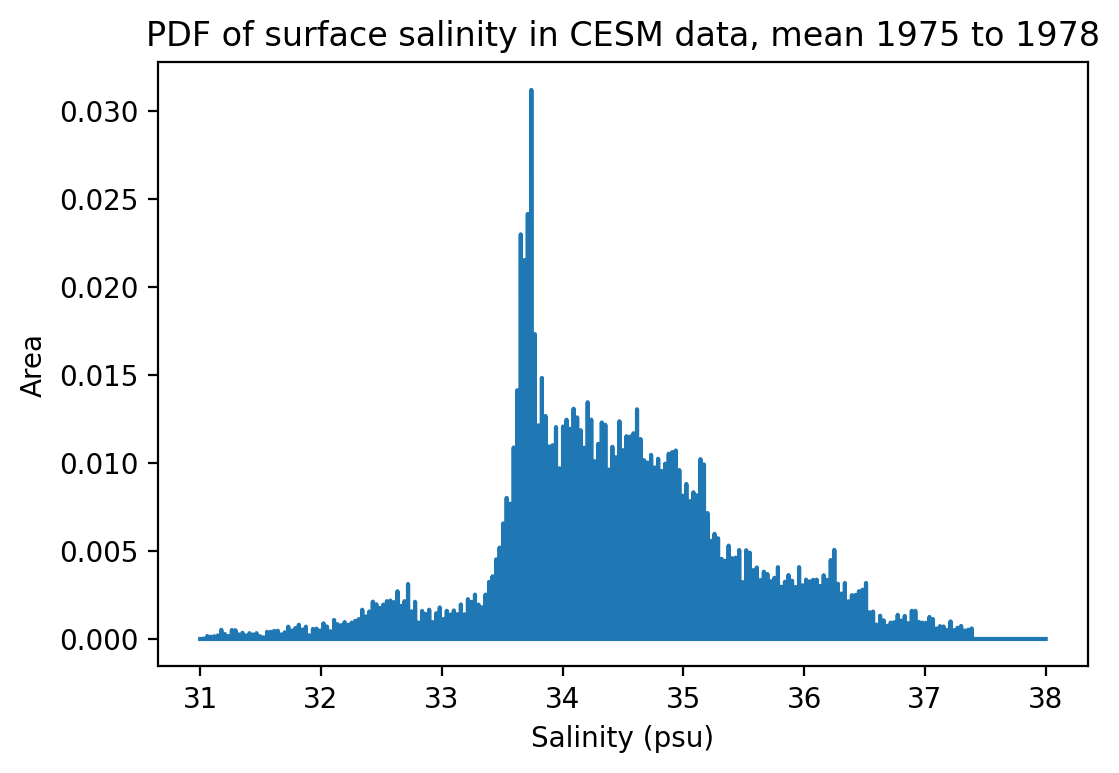

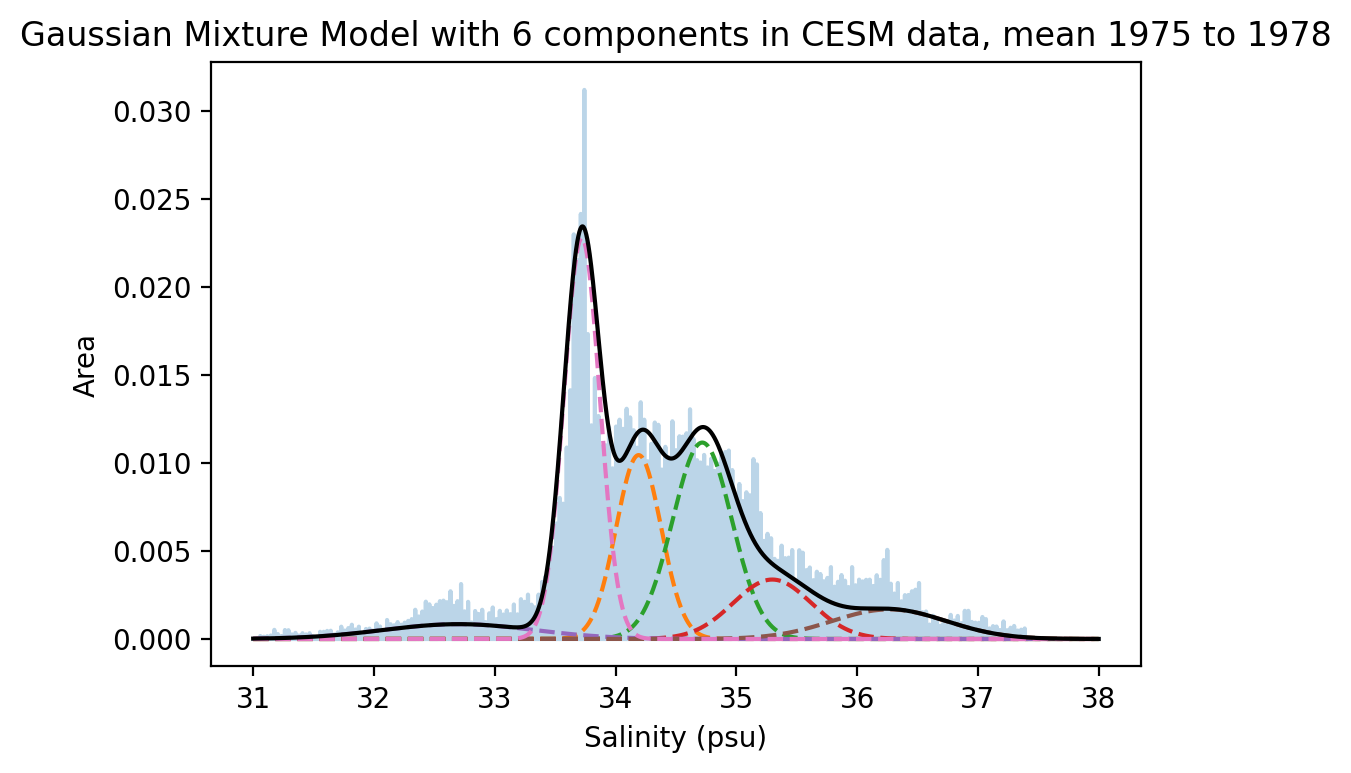

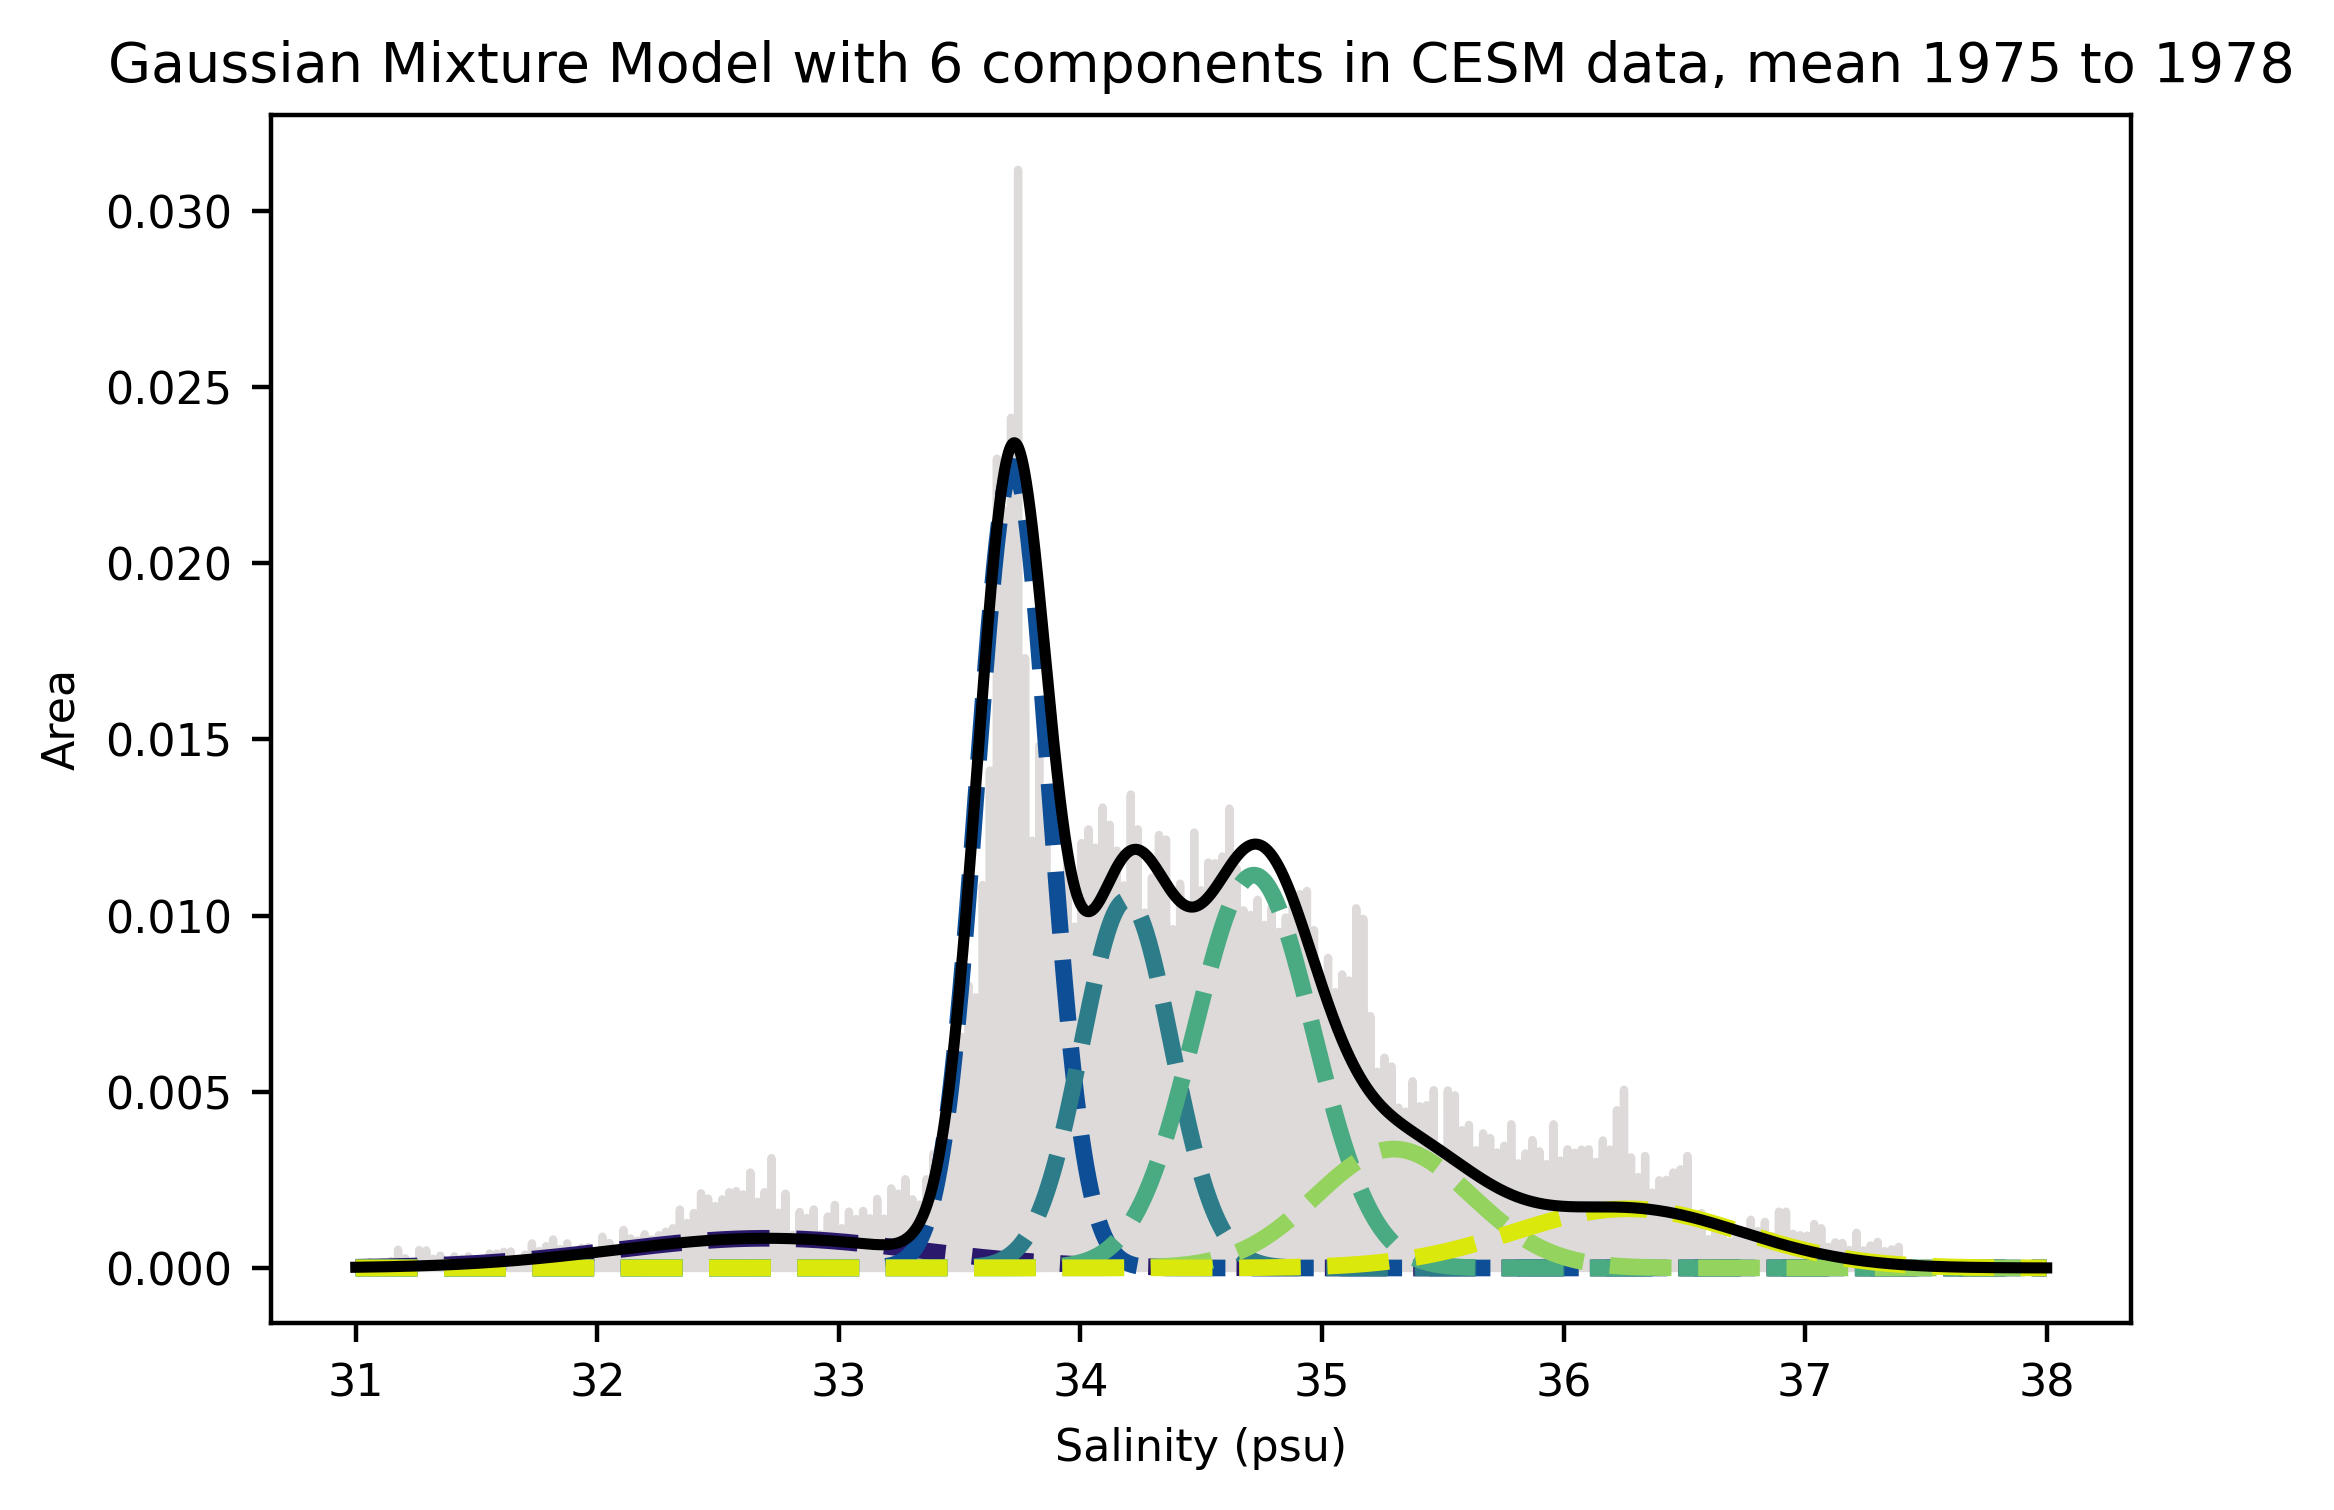

In [9]:
import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools') #make this the directory where the tools folder lives for you


n=6 
%load_ext autoreload 
%autoreload 2

#import seaborn as sns
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300
#sns.set_style(style="whitegrid") #comment out if don't want seaborn background

from clustering_tools import *
mean_con,sigma_con,weights_con,gm=GMM_timedep((salt_avg_1975to2020[0*12:3*12,:,:].mean('time')).where(salt_avg[0,:,:].latitude<65),n,'CESM data, mean 1975 to 1978',precise=0,matching_paper=1) #take mean over first year

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


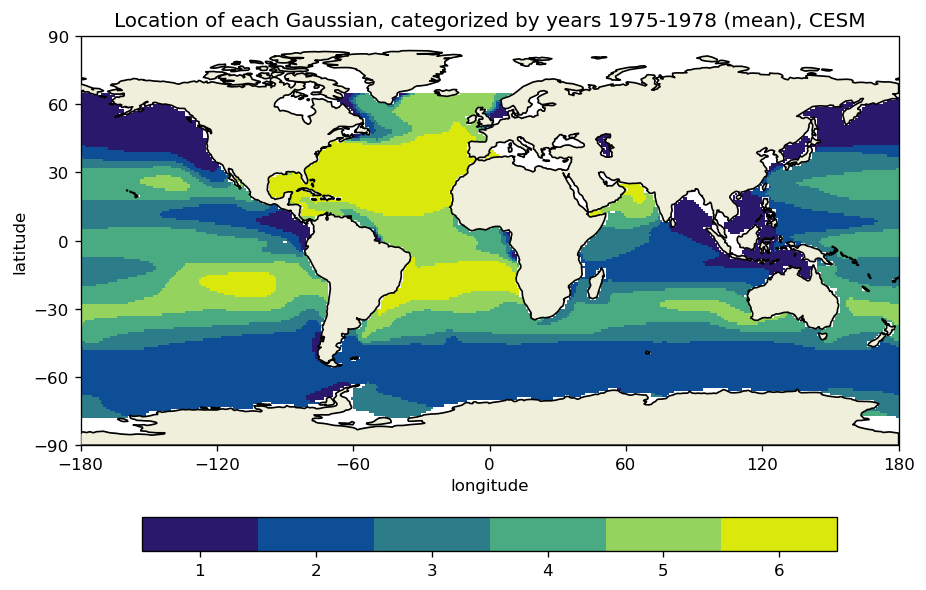

In [10]:
from clustering_tools import clusters
%load_ext autoreload
%autoreload 2
#y,a2=clusters(gm,regrid_iap[0:3].mean('time'),'Location of each Gaussian, categorized by years 1975-1978 (mean), IAP',n)
y,a2=clusters(gm,salt_avg_1975to2020[0*12:3*12,:,:].mean('time'),'Location of each Gaussian, categorized by years 1975-1978 (mean), CESM',n,matching_paper=1) #put on the last parameter if want colours to match the line plots of salinity

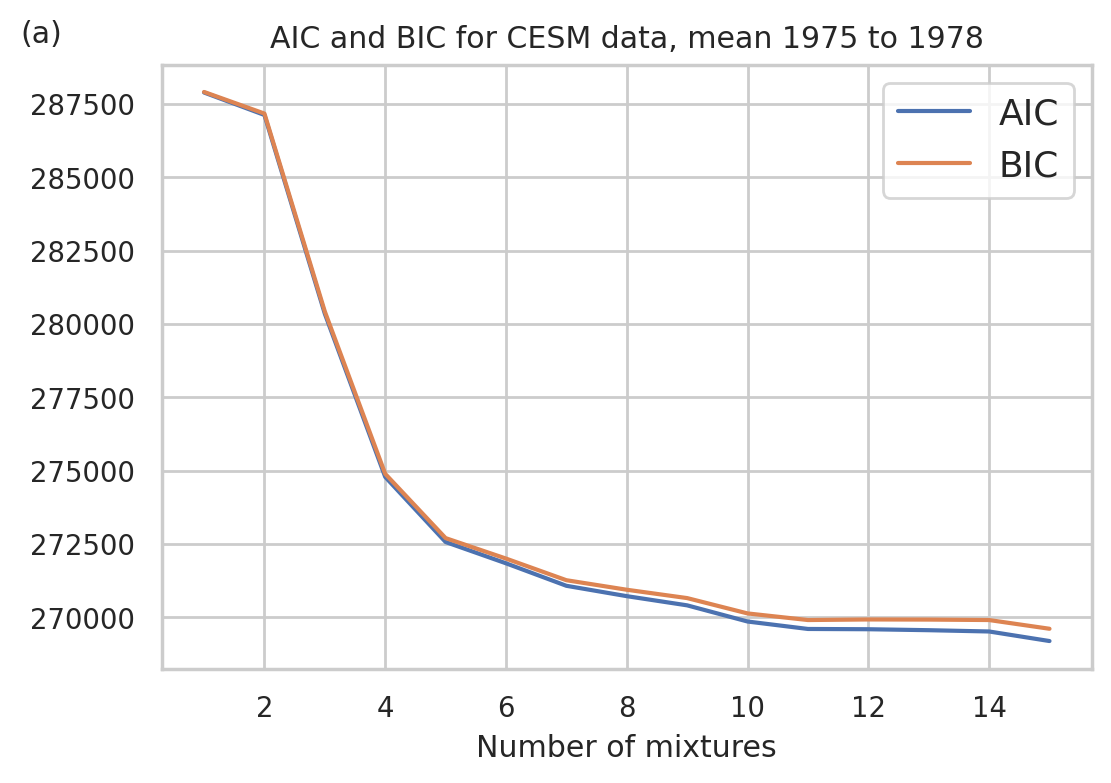

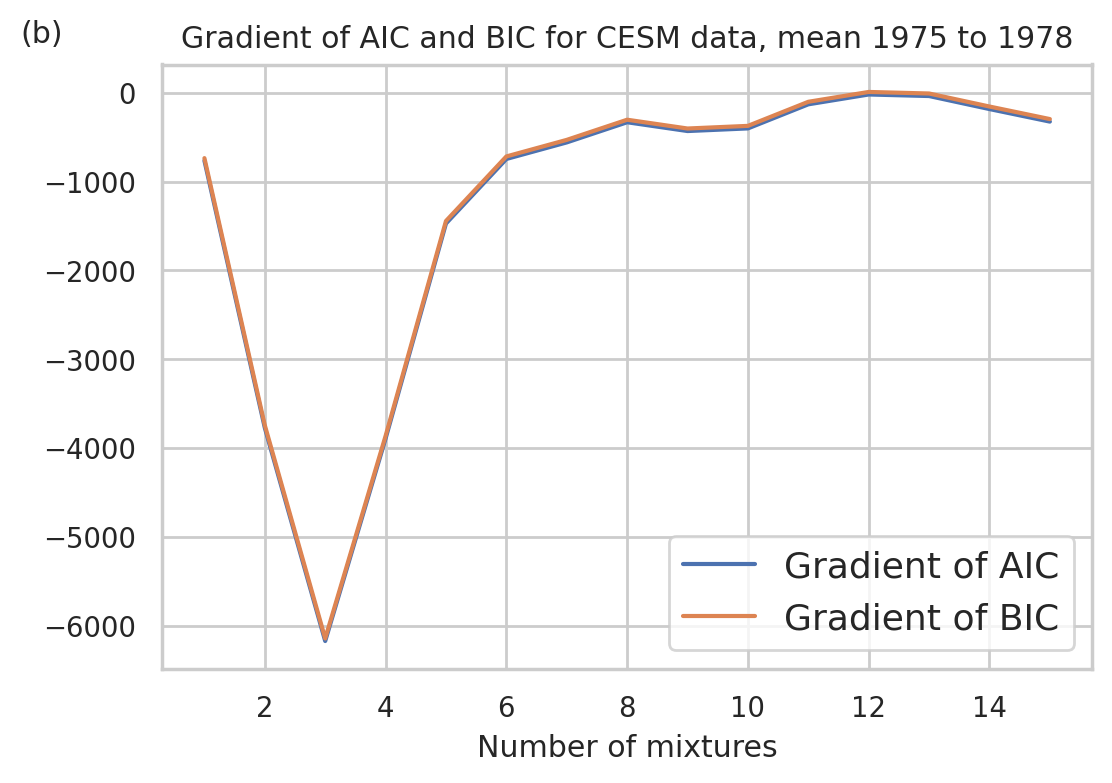

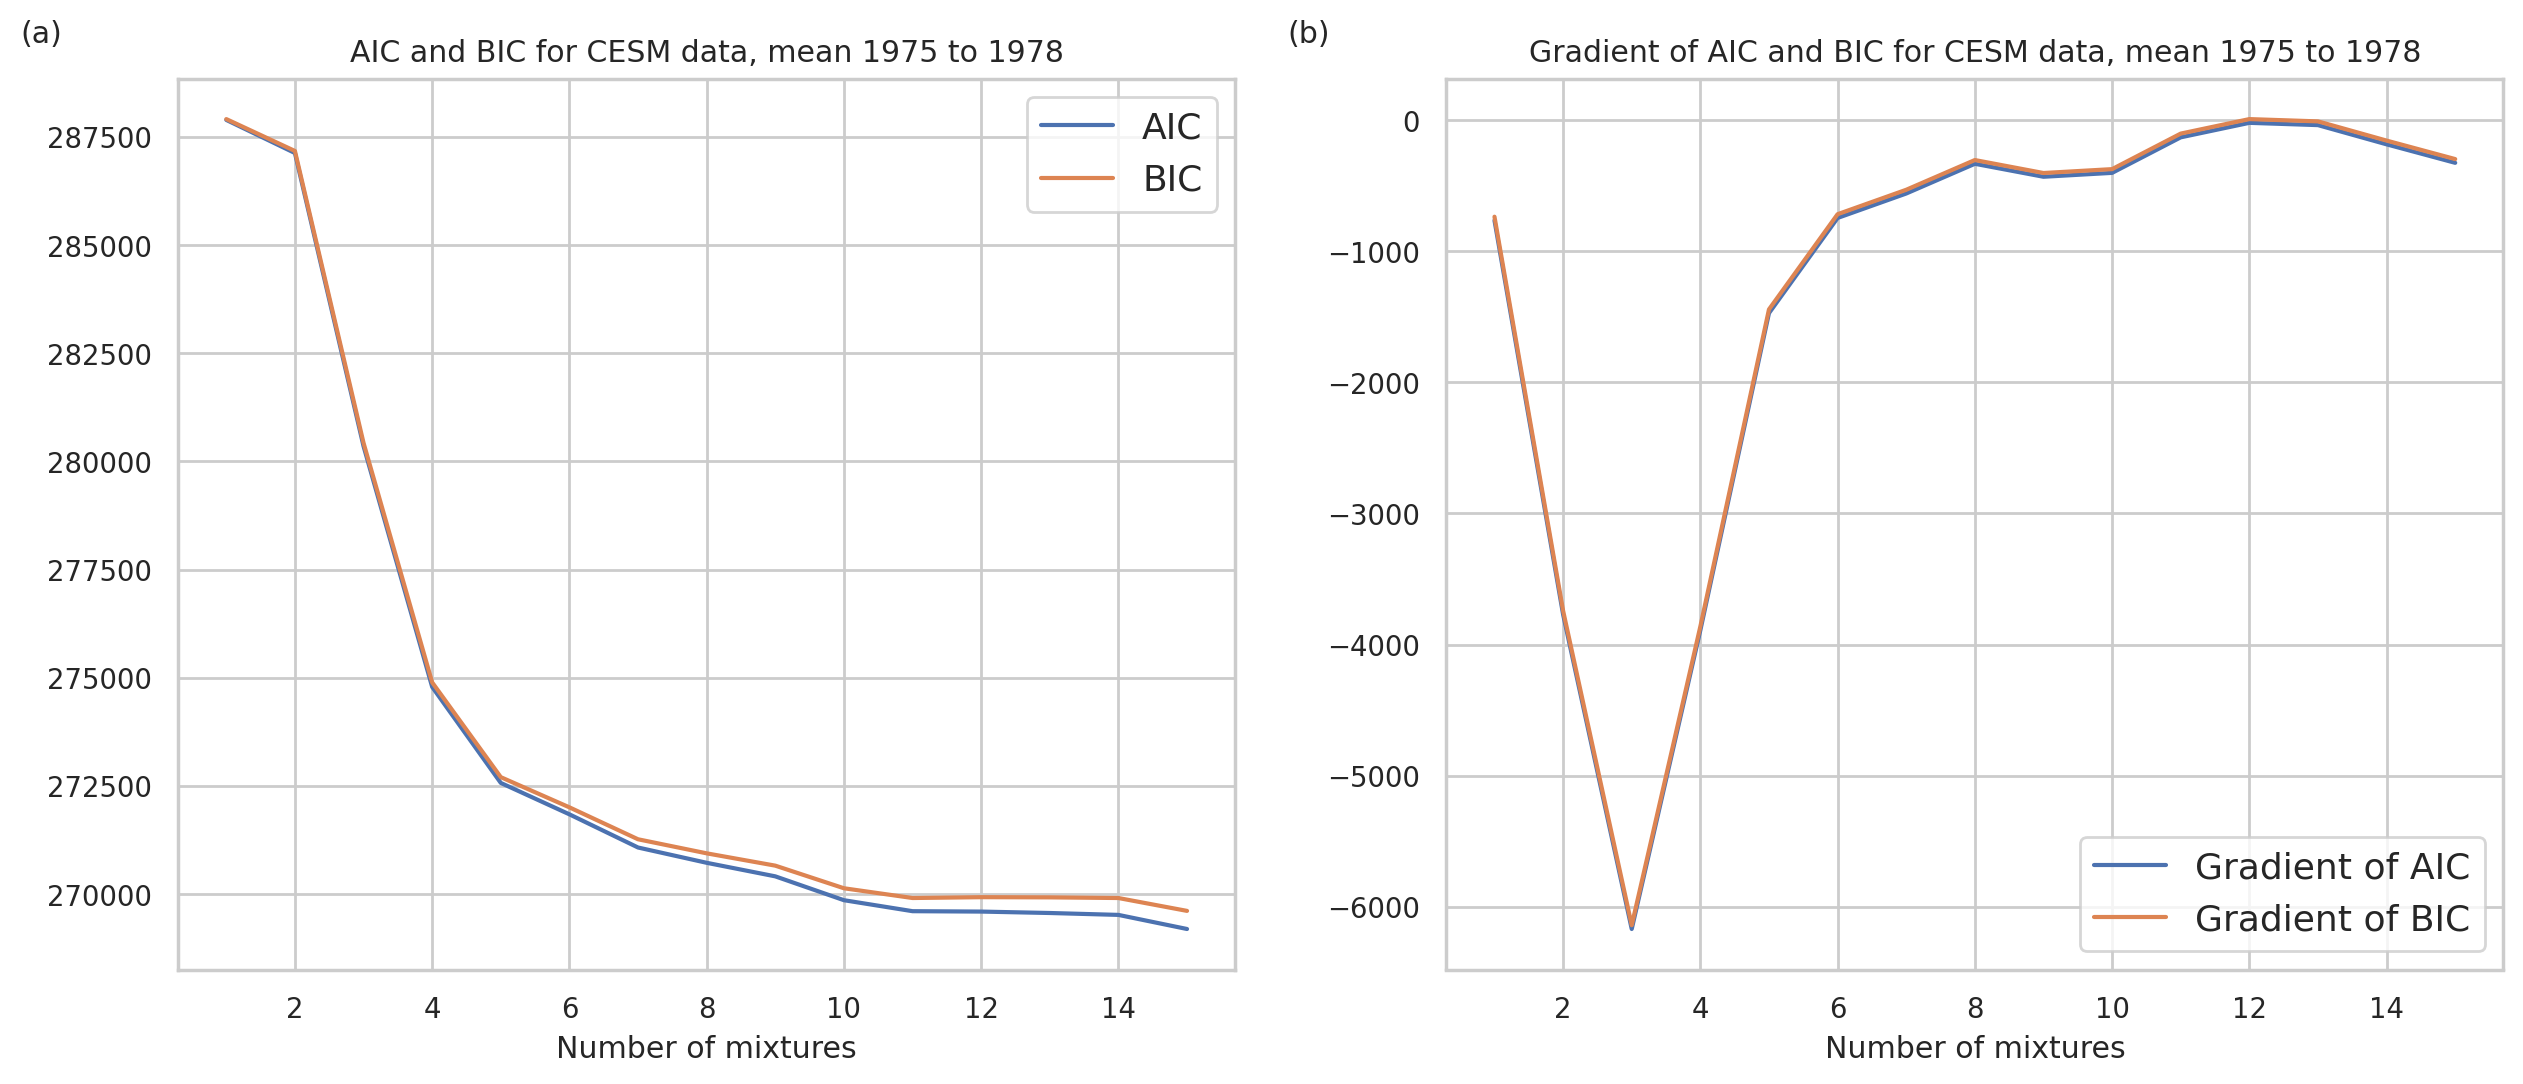

In [42]:
#Look at AIC and BIC metrics
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
AIC_BIC_timedep((salt_avg_1975to2020[0*12:3*12,:,:].mean('time')).where(salt_avg[0,:,:].latitude<65),'CESM data, mean 1975 to 1978',subplot_label='(a)',subplot_label2='(b)')
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

#mpl.pyplot.savefig('AIC_BIC_CESM.png', dpi=300,bbox_inches='tight')


Now that we have the clusters, we find the trend in the salinity in each of these regions over time. First we define a function which allows us to take an area weighted mean and then apply this to each of the clusters

In [11]:
def area_weighted_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()/((area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()
def area_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

In [12]:
s=(salt_avg_1975to2020[0*12:3*12,:,:].mean('time')).where(salt_avg.latitude<65)

x=np.linspace(31,38,10000)
#we have a 50 year time series, we want to find the mean salt at each region defined by the first year at each of these years
salt_cesm=np.empty([50,n])
temp_cesm=np.empty([50,n])
for j in range(0,50):
    s_new=(salt_avg_1975to2020[j*12:(j+1)*12,:,:].mean('time')).where(salt_avg.latitude<65)
    t_new=(temp_avg_1975to2020[j*12:(j+1)*12,:,:].mean('time')).where(temp_avg.latitude<65)
    for i in range(0,n):
        salt_cesm[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_cesm[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)

Plot the timeseries of mean salinity in each cluster over time

Text(0.5, 1.0, 'Change in salinity in each region, CESM ensemble mean')

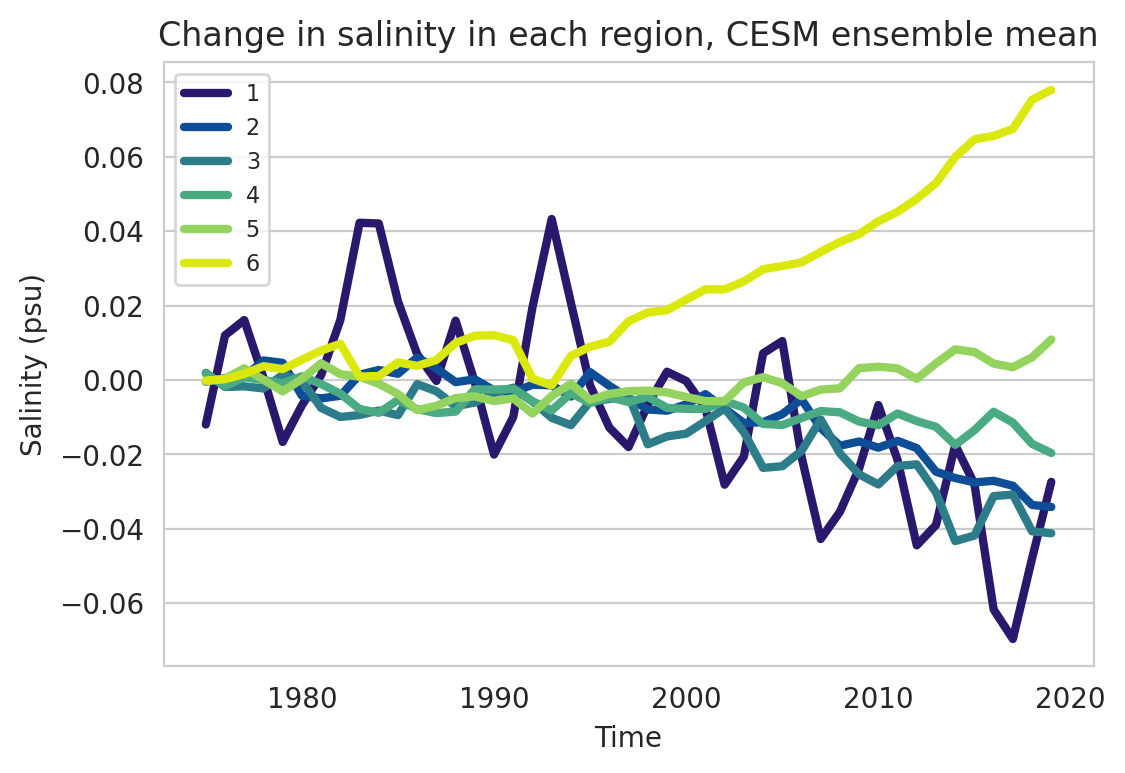

In [13]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
change_cesm=salt_cesm[:,:]-np.mean(salt_cesm[0:2,:],0)
fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_cesm[0:45],linewidth=3)
plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, CESM ensemble mean')
#mpl.pyplot.savefig('CESM_mean_salinity.png', dpi=500,bbox_inches='tight')

Text(0.5, 1.0, 'Change in temperature in each region, CESM ensemble mean')

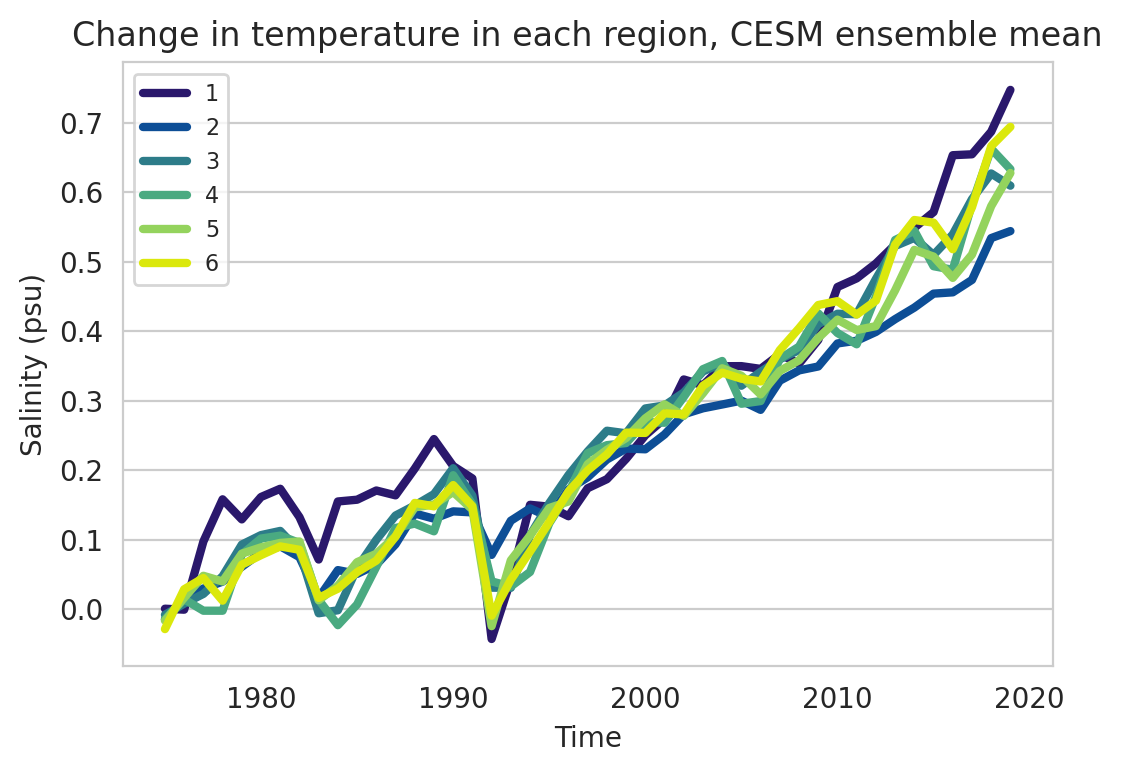

In [14]:
change_temp_cesm=temp_cesm[:,:]-np.mean(temp_cesm[0:2,:],0)

import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_temp_cesm[0:45],linewidth=3)
plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in temperature in each region, CESM ensemble mean')
#mpl.pyplot.savefig('CESM_mean_temperature.png', dpi=500,bbox_inches='tight')

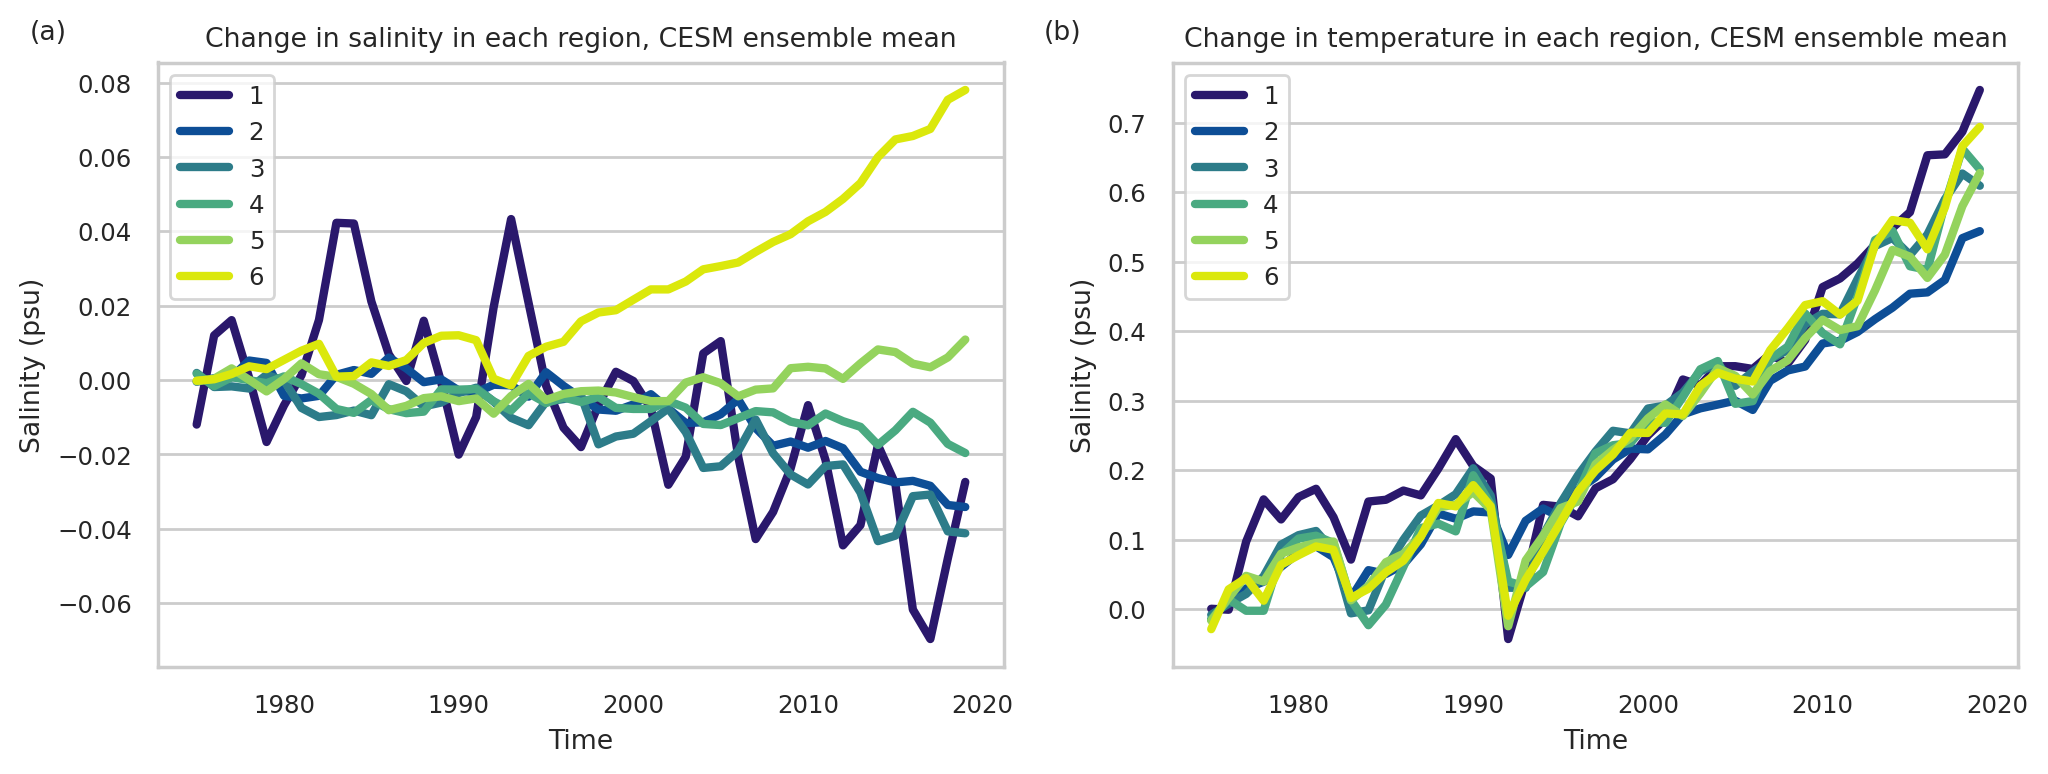

In [15]:
import seaborn as sns
sns.set(font_scale=0.8)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))

ax1.xaxis.grid()
from cycler import cycler
ax1.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax1.plot(np.linspace(1975,2019,45),change_cesm[0:45],linewidth=3)
ax1.legend(['1','2','3','4','5','6'],loc='upper left')
ax1.set_xlabel('Time')
ax1.set_ylabel('Salinity (psu)')
ax1.set_title('Change in salinity in each region, CESM ensemble mean')
ax1.text(-0.13, 1.05, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)



ax2.xaxis.grid()
from cycler import cycler
ax2.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax2.plot(np.linspace(1975,2019,45),change_temp_cesm[0:45],linewidth=3)
ax2.legend(['1','2','3','4','5','6'],loc='upper left')
ax2.set_xlabel('Time')
ax2.set_ylabel('Salinity (psu)')
ax2.set_title('Change in temperature in each region, CESM ensemble mean')
ax2.text(-0.13, 1.05, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

import matplotlib as mpl
mpl.pyplot.savefig('CESM_ensemble_mean_dual.png', dpi=500,bbox_inches='tight')

Now we need to regrid the FAFMIP response functions to the clusters that were found above

In [16]:
from fafmip_gridding_tools import regridded_fafmip_temp
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_stress,temp_mom_stress,temp_had_stress,temp_access_stress,temp_mit_heat,temp_mom_heat,temp_had_heat,temp_access_heat,temp_mit_water,temp_mom_water,temp_had_water,temp_access_water=regridded_fafmip_temp(salt_avg_1975to2020,area,a2,n)

from fafmip_gridding_tools import regridded_fafmip
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_stress,salt_mom_stress,salt_had_stress,salt_access_stress,salt_mit_heat,salt_mom_heat,salt_had_heat,salt_access_heat,salt_mit_water,salt_mom_water,salt_had_water,salt_access_water=regridded_fafmip(salt_avg_1975to2020,area,a2,n)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Perform the linear response theory itself. 
There's a parameter that let's you choose if the solution is area weighted or not (i.e. if the Ax=b problem is weighted by the area of each region -- AWx=Wb)

In [18]:
#Get the area of each cluster
def area_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

#DEFINE THE AREA OF EACH CLUSTER
s=(salt_avg_1975to2020[0*12:3*12,:,:].mean('time')).where(salt_avg.latitude<65)
ones_grid=salt_avg_1975to2020[0,:,:].where(salt_avg_1975to2020[0,:,:]==1, other=1)
area_cluster=np.empty(6)
for i in range(0,n):
    area_cluster[i]=area_disjoint(area,i,s,ones_grid,x,a2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


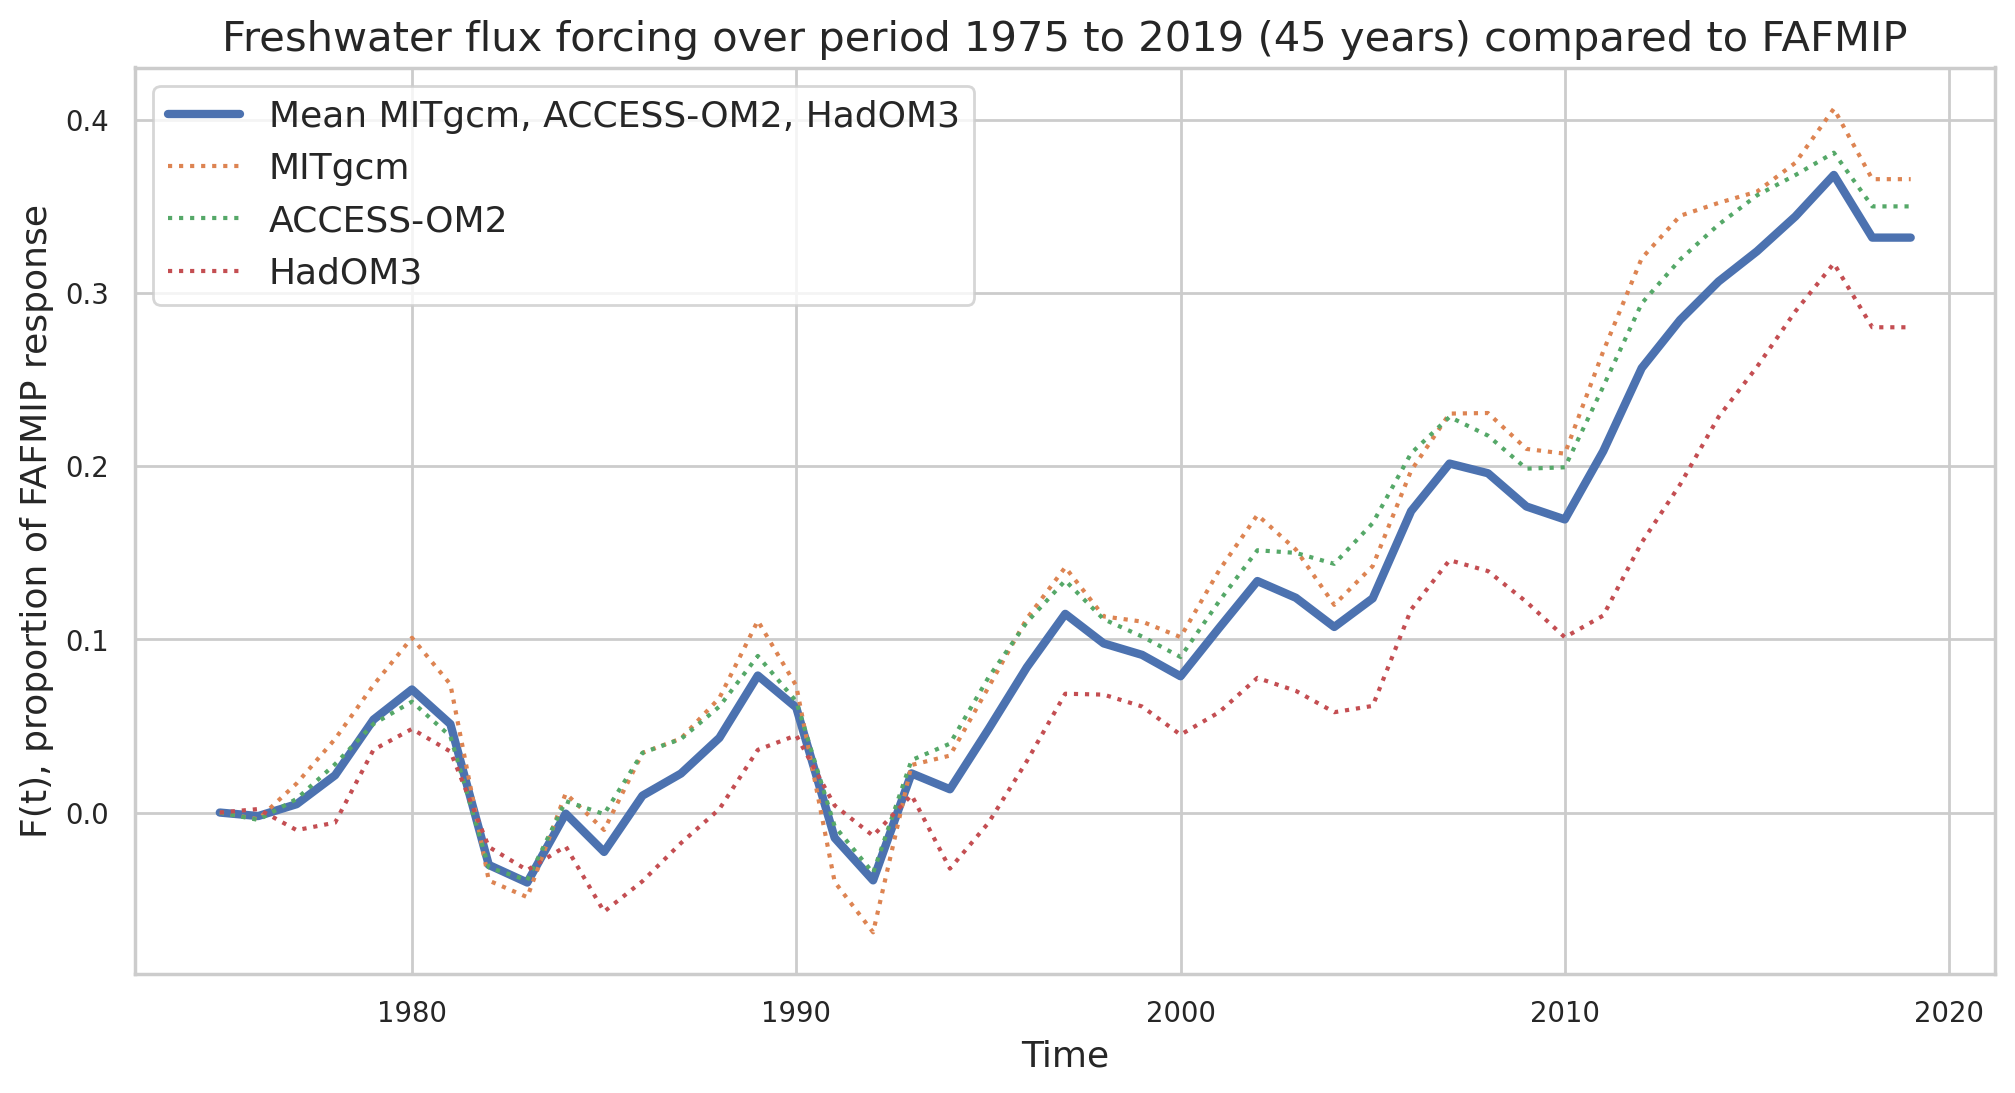

In [41]:
from linear_response_tools import linear_response_single
%load_ext autoreload
%autoreload 2

change_water,change_heat=linear_response_single(change_cesm[0:45],change_temp_cesm[0:45],a2,salt_avg_1975to2020,n,weighted=1,area_cluster=area_cluster,title='Freshwater flux forcing over period 1975 to 2019 (45 years) compared to FAFMIP') #this is area weighted
mpl.pyplot.savefig('flux_proportion_CESM_ensemble.png', dpi=300,bbox_inches='tight')

In [20]:
change_water

0.3245774310909684

# Make figures for the paper
Here we make the linearity assumption figure (Fig 5), the change in salinity in each region (Fig 4), and Figures 3a/b

Test linearity assumption

In [21]:
import sys
import warnings
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools')

from fafmip_gridding_tools import regridded_fafmip_temp
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_stress,temp_mom_stress,temp_had_stress,temp_access_stress,temp_mit_heat,temp_mom_heat,temp_had_heat,temp_access_heat,temp_mit_water,temp_mom_water,temp_had_water,temp_access_water=regridded_fafmip_temp(salt_avg_1975to2020,area,a2,n)

from fafmip_gridding_tools import regridded_fafmip
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_stress,salt_mom_stress,salt_had_stress,salt_access_stress,salt_mit_heat,salt_mom_heat,salt_had_heat,salt_access_heat,salt_mit_water,salt_mom_water,salt_had_water,salt_access_water=regridded_fafmip(salt_avg_1975to2020,area,a2,n)
    
from fafmip_gridding_tools import regridded_fafmip_temp_all_control
%load_ext autoreload
%autoreload 2
with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_all,temp_had_all,temp_access_all, temp_access_con, temp_mit_con, temp_had_con=regridded_fafmip_temp_all_control(salt_avg_1975to2020,area,a2,n) 
    
from fafmip_gridding_tools import regridded_fafmip_all_control
%load_ext autoreload
%autoreload 2
with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_all,salt_mom_all, salt_had_all,salt_access_all, salt_access_con, salt_had_con, salt_mit_con=regridded_fafmip_all_control(salt_avg_1975to2020,area,a2,n) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
#Define changes in the FAFMIP stuff (comparing to control)

#CHANGE IN MITgcm
#TEMP
change_temp_mit_stress=temp_mit_stress[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_water=temp_mit_water[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_heat=temp_mit_heat[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_all=temp_mit_all[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)

#SALT
change_salt_mit_stress=salt_mit_stress[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_water=salt_mit_water[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_heat=salt_mit_heat[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_all=salt_mit_all[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)

#CHANGE IN ACCESS
#TEMP
change_temp_access_stress=temp_access_stress[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_water=temp_access_water[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_heat=temp_access_heat[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_all=temp_access_all[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)

#SALT 
change_salt_access_stress=salt_access_stress[60:67,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_water=salt_access_water[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_heat=salt_access_heat[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_all=salt_access_all[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)


#CHANGE IN HAD
#TEMP
change_temp_had_stress=temp_had_stress[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_water=temp_had_water[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_heat=temp_had_heat[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_all=temp_had_all[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)

#SALT
change_salt_had_stress=salt_had_stress[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_water=salt_had_water[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_heat=salt_had_heat[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_all=salt_had_all[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)

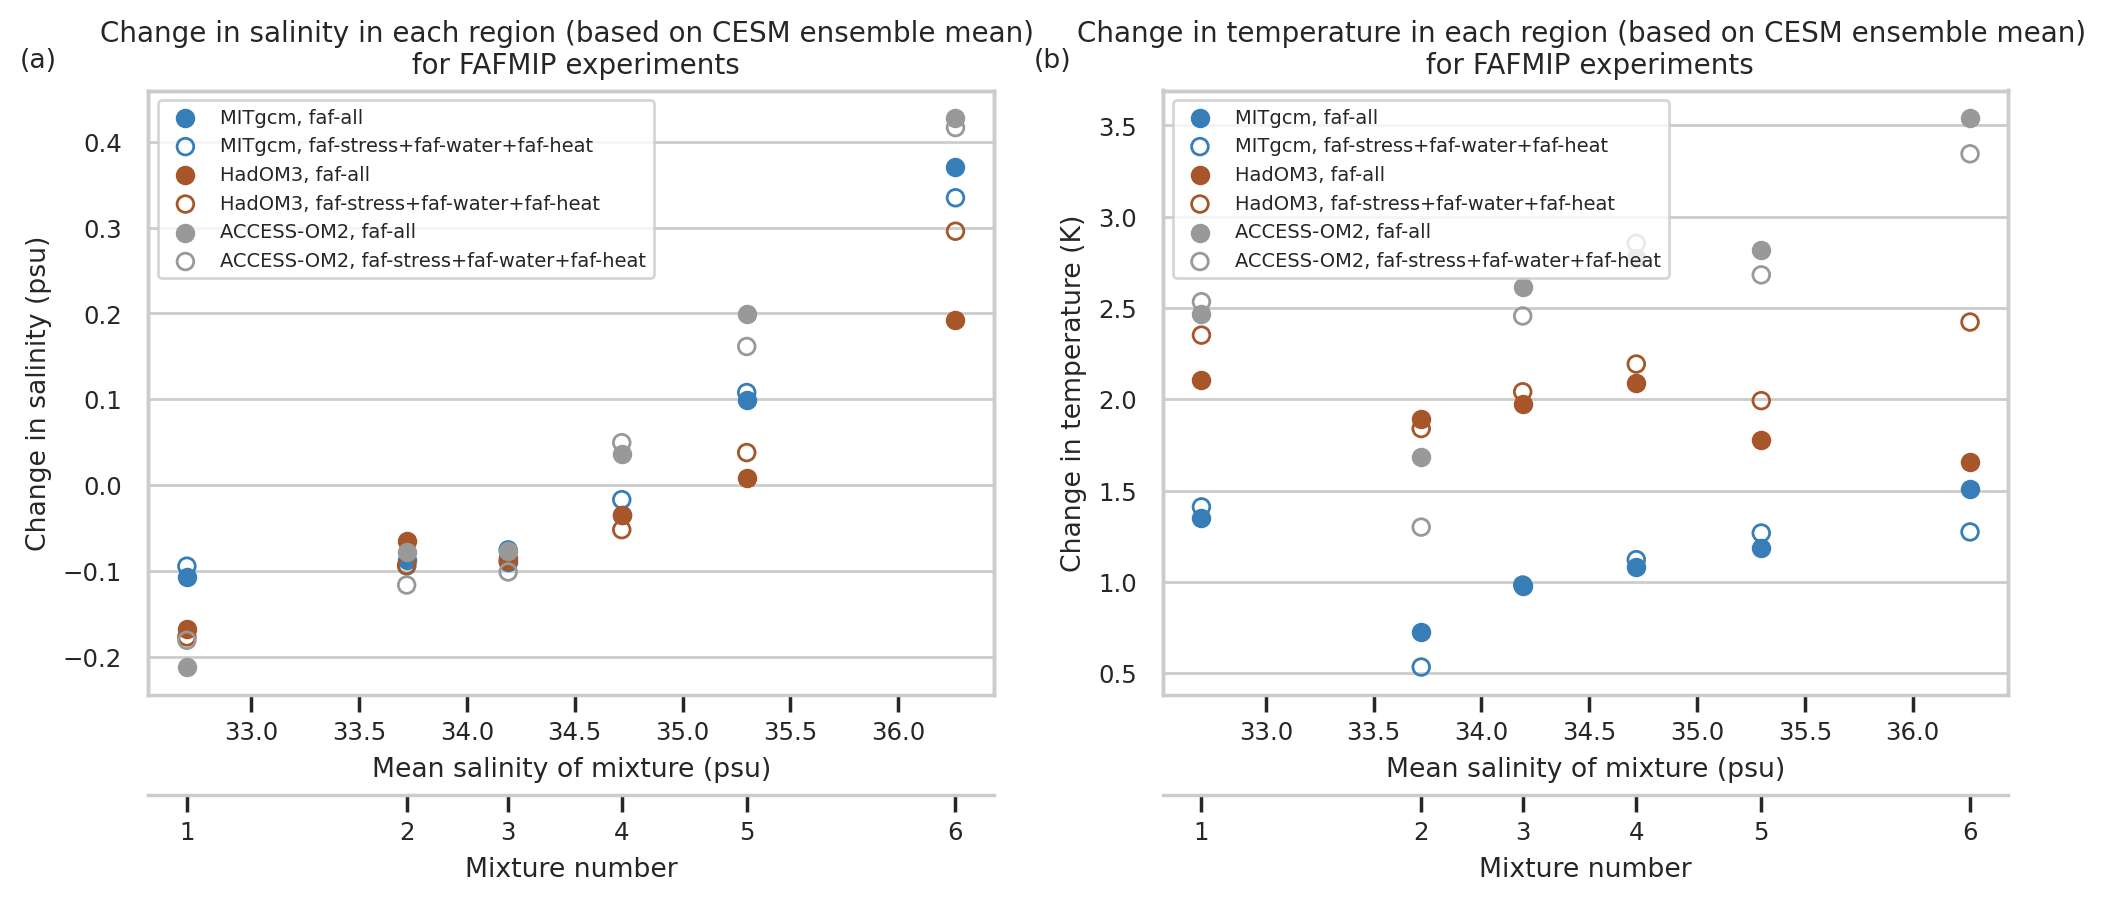

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))


sns.set(font_scale=0.8)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background



#LEFT PLOT
ax1_twin = ax1.twiny()
ax1_twin.xaxis.grid()
ax1.xaxis.grid()
ax1.scatter(mean_con,change_salt_mit_all,color="#377eb8",label="MITgcm, faf-all")
ax1.scatter(mean_con,change_salt_mit_heat+change_salt_mit_water+change_salt_mit_stress,color='none', edgecolors="#377eb8", label="MITgcm, faf-stress+faf-water+faf-heat")

ax1.scatter(mean_con,change_salt_had_all,color="#a65628",label="HadOM3, faf-all")
ax1.scatter(mean_con,change_salt_had_heat+change_salt_had_water+change_salt_had_stress,color="none",edgecolors="#a65628", label="HadOM3, faf-stress+faf-water+faf-heat")

ax1.scatter(mean_con,change_salt_access_all,color="#999999",label="ACCESS-OM2, faf-all")
ax1.scatter(mean_con,change_salt_access_heat+change_salt_access_water+change_salt_access_stress,color="none",edgecolors="#999999", label="ACCESS-OM2, faf-stress+faf-water+faf-heat")
ax1.set_title('Change in salinity in each region (based on CESM ensemble mean) \n for FAFMIP experiments',fontsize=10)
ax1.set_xlabel('Mean salinity of mixture (psu)')
ax1.set_ylabel('Change in salinity (psu)')
ax1.legend(fontsize=7)
ax1.text(-0.13, 1.05, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax1_twin.set_xticks(newpos)


ax1_twin.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax1_twin.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax1_twin.spines['bottom'].set_position(('outward', 36))
ax1_twin.set_xlabel('Mixture number')
ax1_twin.set_xlim(ax1.get_xlim())
ax1_twin.set_xticks(newpos)
ax1_twin.set_xticklabels(newlabel)

#RIGHT PLOT
ax2.xaxis.grid()
ax2.scatter(mean_con,change_temp_mit_all,color="#377eb8",label="MITgcm, faf-all")
ax2.scatter(mean_con,change_temp_mit_heat+change_temp_mit_water+change_temp_mit_stress,color='none', edgecolors="#377eb8", label="MITgcm, faf-stress+faf-water+faf-heat")
ax2.scatter(mean_con,change_temp_had_all,color="#a65628",label="HadOM3, faf-all")
ax2.scatter(mean_con,change_temp_had_heat+change_temp_had_water+change_temp_had_stress,color='none', edgecolors="#a65628", label="HadOM3, faf-stress+faf-water+faf-heat")
ax2.scatter(mean_con,change_temp_access_all,color="#999999",label="ACCESS-OM2, faf-all")
ax2.scatter(mean_con,change_temp_access_heat+change_temp_access_water+change_temp_access_stress,color="none",edgecolors="#999999", label="ACCESS-OM2, faf-stress+faf-water+faf-heat")
ax2.set_title('Change in temperature in each region (based on CESM ensemble mean) \n for FAFMIP experiments',fontsize=10)
ax2.set_xlabel('Mean salinity of mixture (psu)')
ax2.set_ylabel('Change in temperature (K)')
ax2.legend(fontsize=7)
ax2.text(-0.13, 1.05, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

ax2_twin = ax2.twiny()
ax2_twin.xaxis.grid()
ax2_twin.set_xticks(newpos)
ax2_twin.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2_twin.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2_twin.spines['bottom'].set_position(('outward', 36))
ax2_twin.set_xlabel('Mixture number')
ax2_twin.set_xlim(ax2.get_xlim())
ax2_twin.set_xticks(newpos)
ax2_twin.set_xticklabels(newlabel)
import matplotlib as mpl
mpl.pyplot.savefig('linearity_assumption_dual_CESM.png', dpi=500,bbox_inches='tight')

In [24]:
np.linalg.norm(change_salt_mit_heat+change_salt_mit_water+change_salt_mit_stress)/np.linalg.norm(change_salt_mit_all)

0.9160593446757094

In [25]:
np.linalg.norm(change_salt_had_heat+change_salt_had_water+change_salt_had_stress)/np.linalg.norm(change_salt_had_all)

1.3384299534901818

In [26]:
np.linalg.norm(change_salt_access_heat+change_salt_access_water+change_salt_access_stress)/np.linalg.norm(change_salt_access_all)

0.9592697802470299

In [27]:
np.linalg.norm(change_temp_mit_heat+change_temp_mit_water+change_temp_mit_stress)/np.linalg.norm(change_temp_mit_all)

0.9736739698311322

In [28]:
np.linalg.norm(change_temp_access_heat+change_temp_access_water+change_temp_access_stress)/np.linalg.norm(change_temp_access_all)

0.9620178785496831

### 2. Now let's look at the change in each region due to each kind of forcing. This is making Figure 4 and Figure S4 in the paper

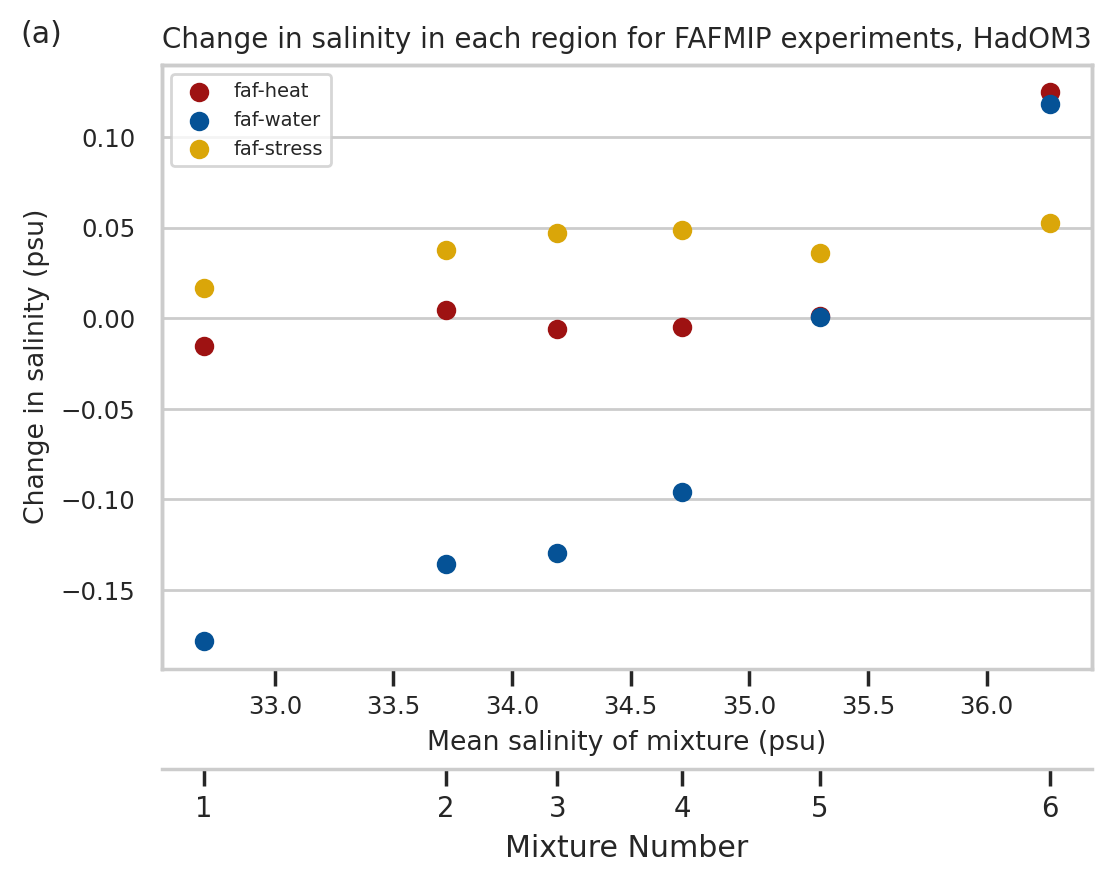

In [29]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_had_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_had_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_had_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in salinity in each region for FAFMIP experiments, HadOM3', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(a)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_hadom3_cesm_clusters_new.png', dpi=500,bbox_inches='tight')

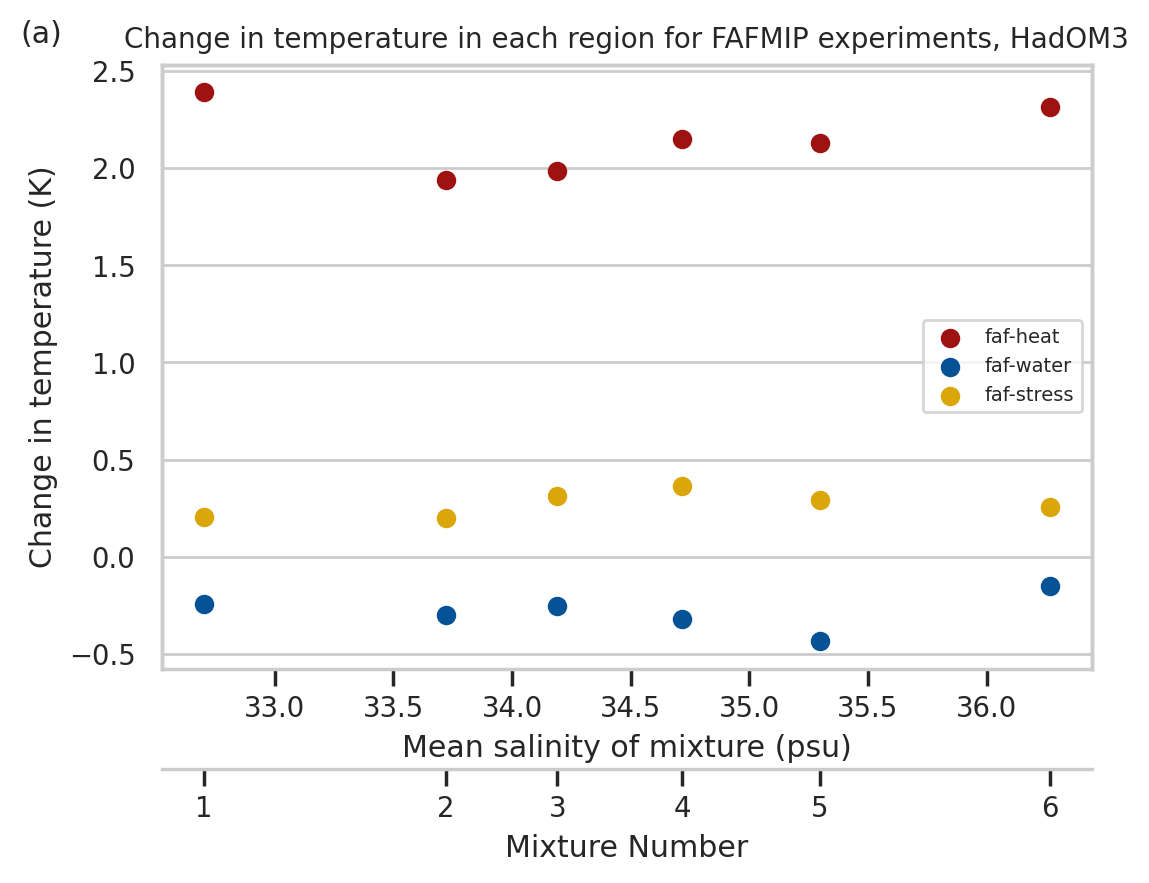

In [30]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_had_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_had_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_had_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, HadOM3', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(a)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
import matplotlib as mpl
mpl.pyplot.savefig('individual_forcings_hadom3_cesm_clusters_new_temp.png', dpi=500,bbox_inches='tight')

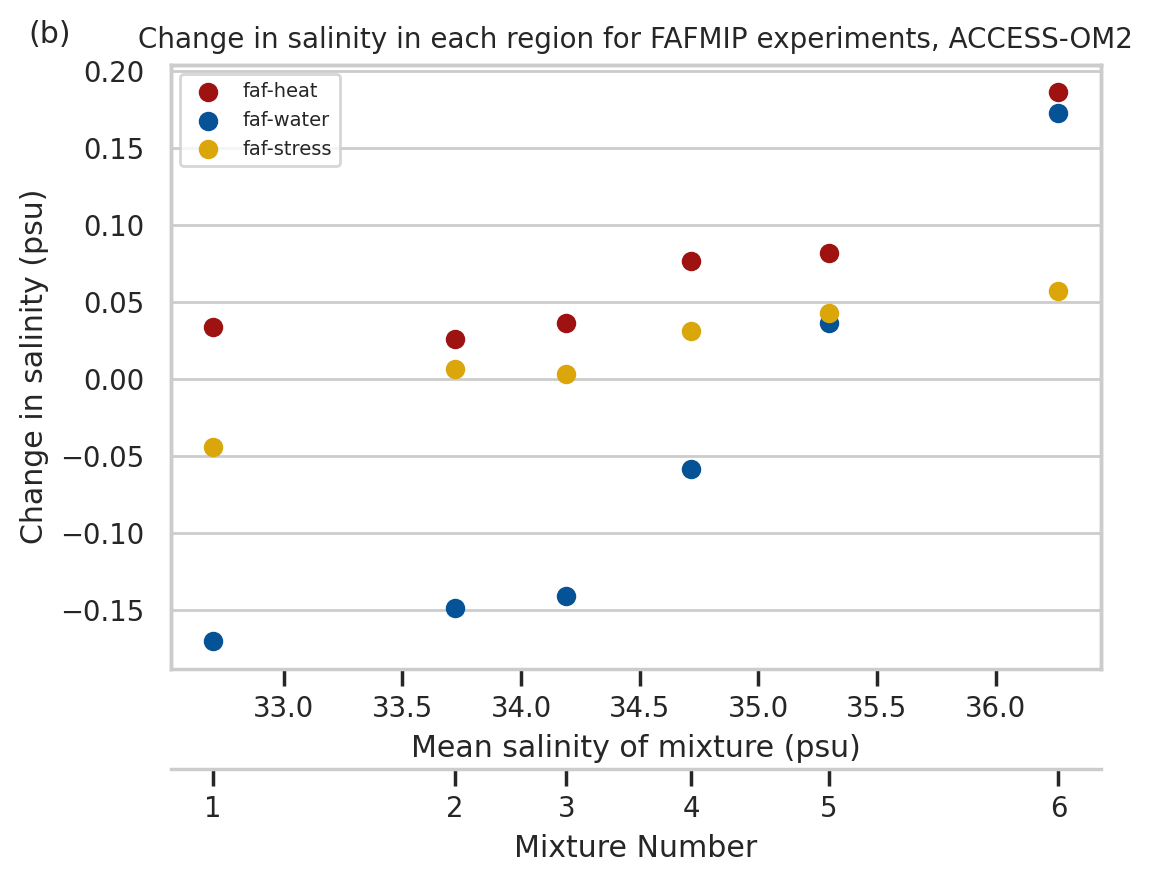

In [31]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_access_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_access_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_access_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in salinity in each region for FAFMIP experiments, ACCESS-OM2', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(b)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_access_cesm_clusters_new.png', dpi=500,bbox_inches='tight')

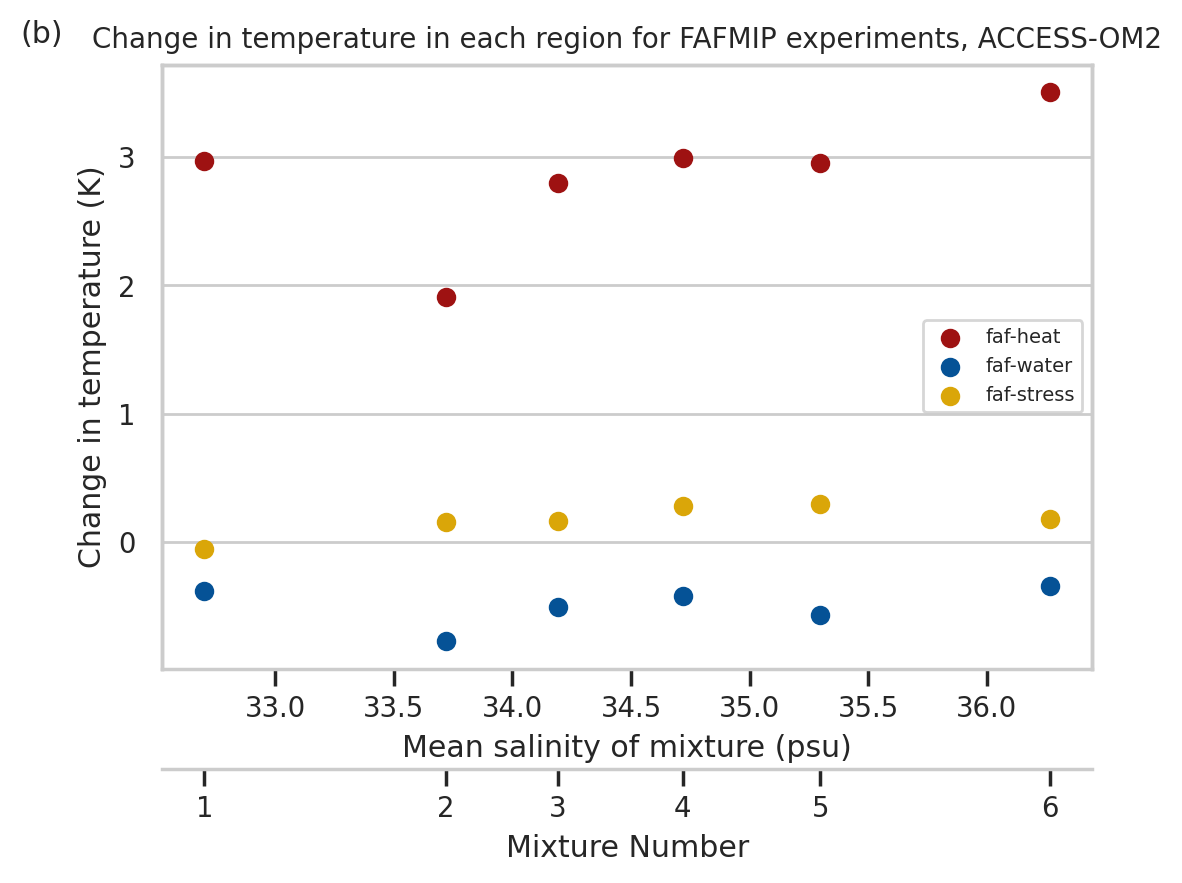

In [32]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_access_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_access_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_access_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, ACCESS-OM2', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(b)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_access_cesm_clusters_new_temp.png', dpi=500,bbox_inches='tight')

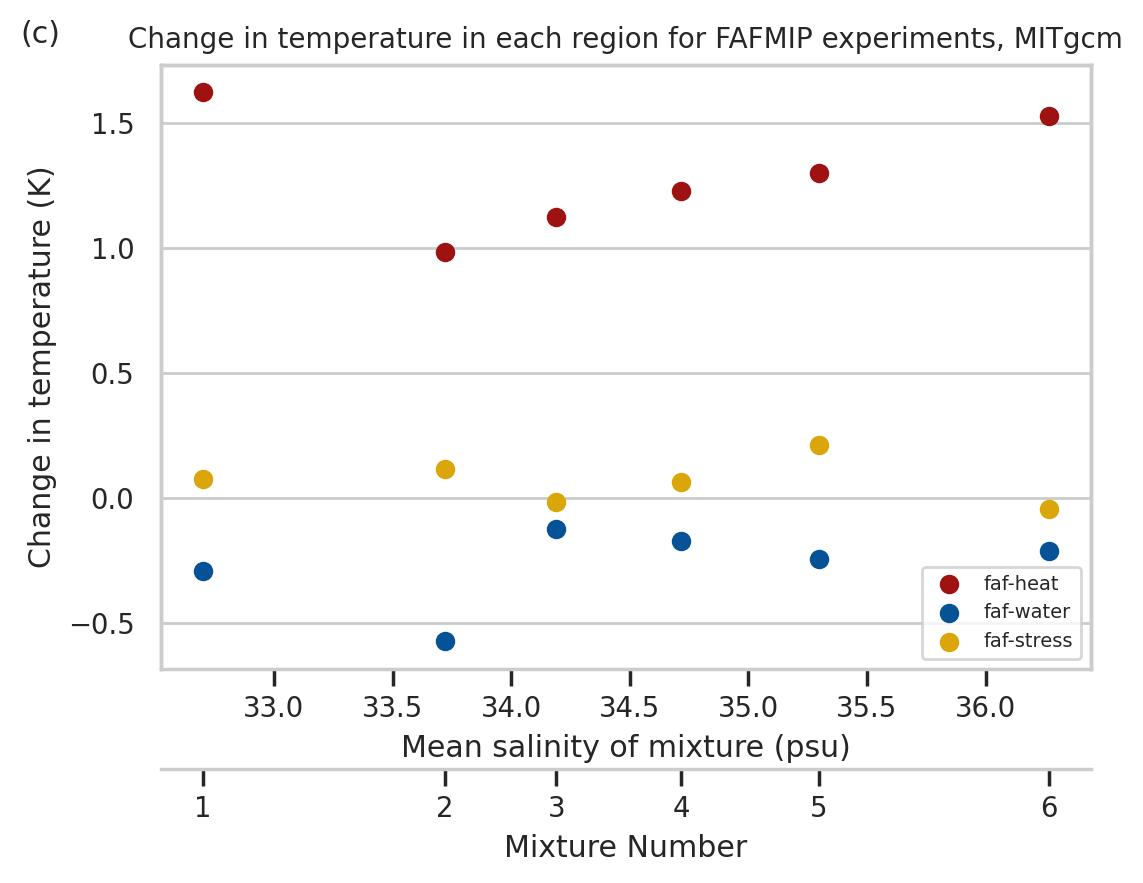

In [33]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_mit_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_mit_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_mit_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, MITgcm', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(c)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_mitgcm_cesm_clusters_new_temp.png', dpi=500,bbox_inches='tight')

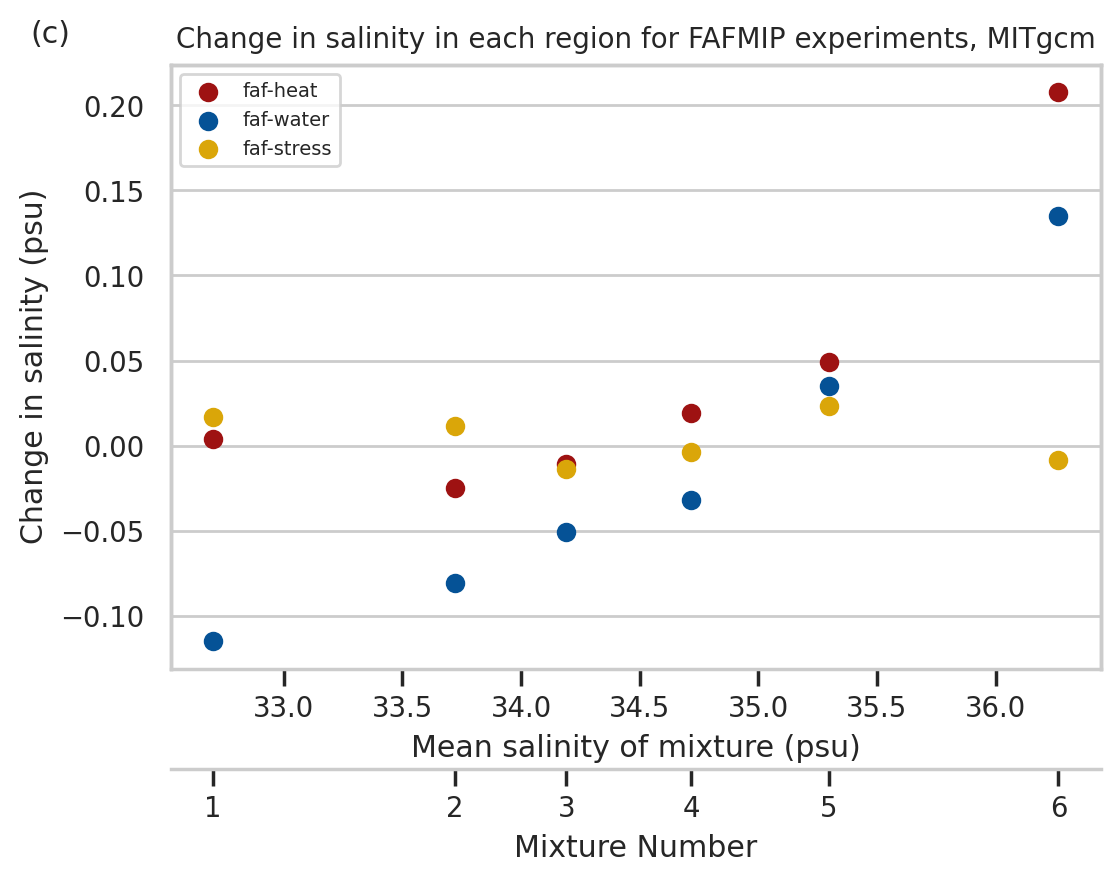

In [34]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_mit_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_mit_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_mit_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in salinity in each region for FAFMIP experiments, MITgcm', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(c)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_mitgcm_cesm_clusters_new.png', dpi=500,bbox_inches='tight')

## Plot the response functions

Text(0.5, 1.0, 'Change in salinity in each region, MITgcm ocean-only FAFMIP, clustering on CESM data')

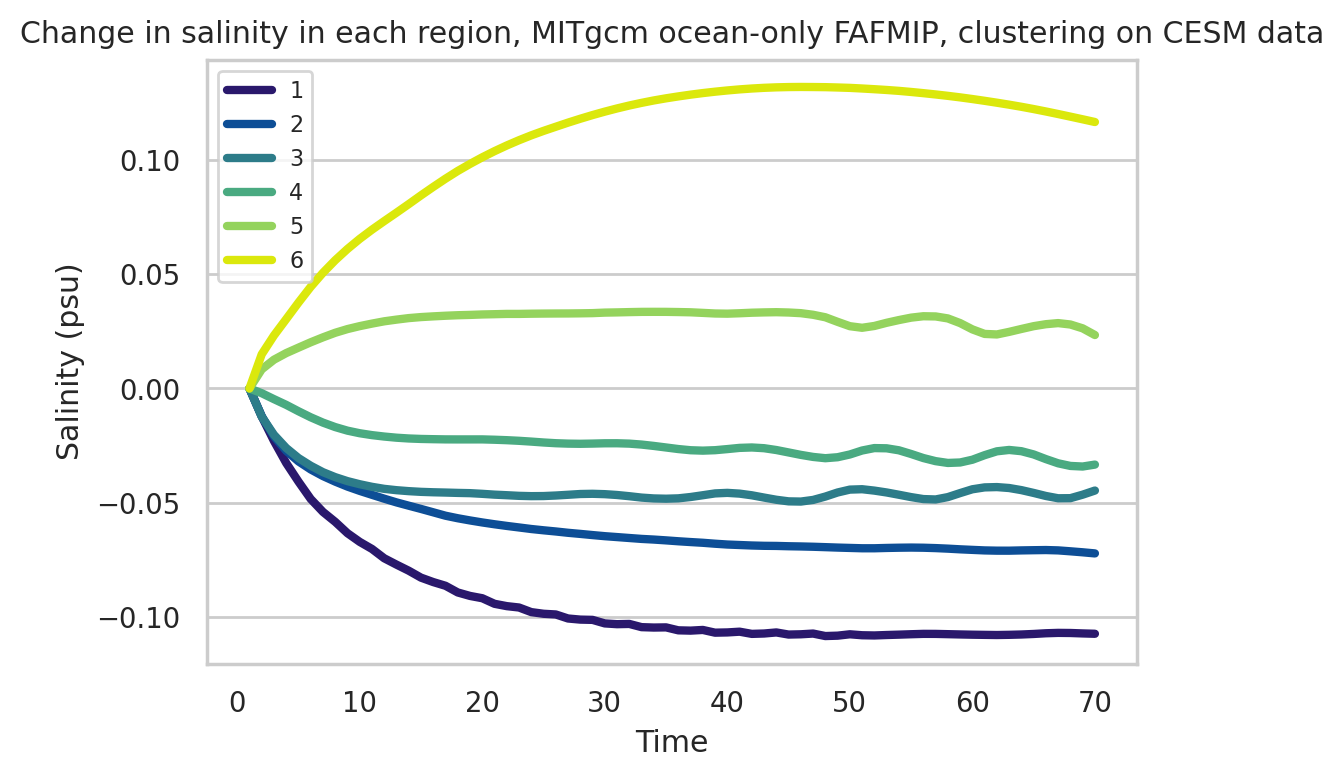

In [35]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_mit_water-np.mean(salt_mit_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, MITgcm ocean-only FAFMIP, clustering on CESM data')

Text(0.5, 1.0, 'Change in salinity in each region, ACCESS-OM2 ocean-only FAFMIP, clustering on CESM data')

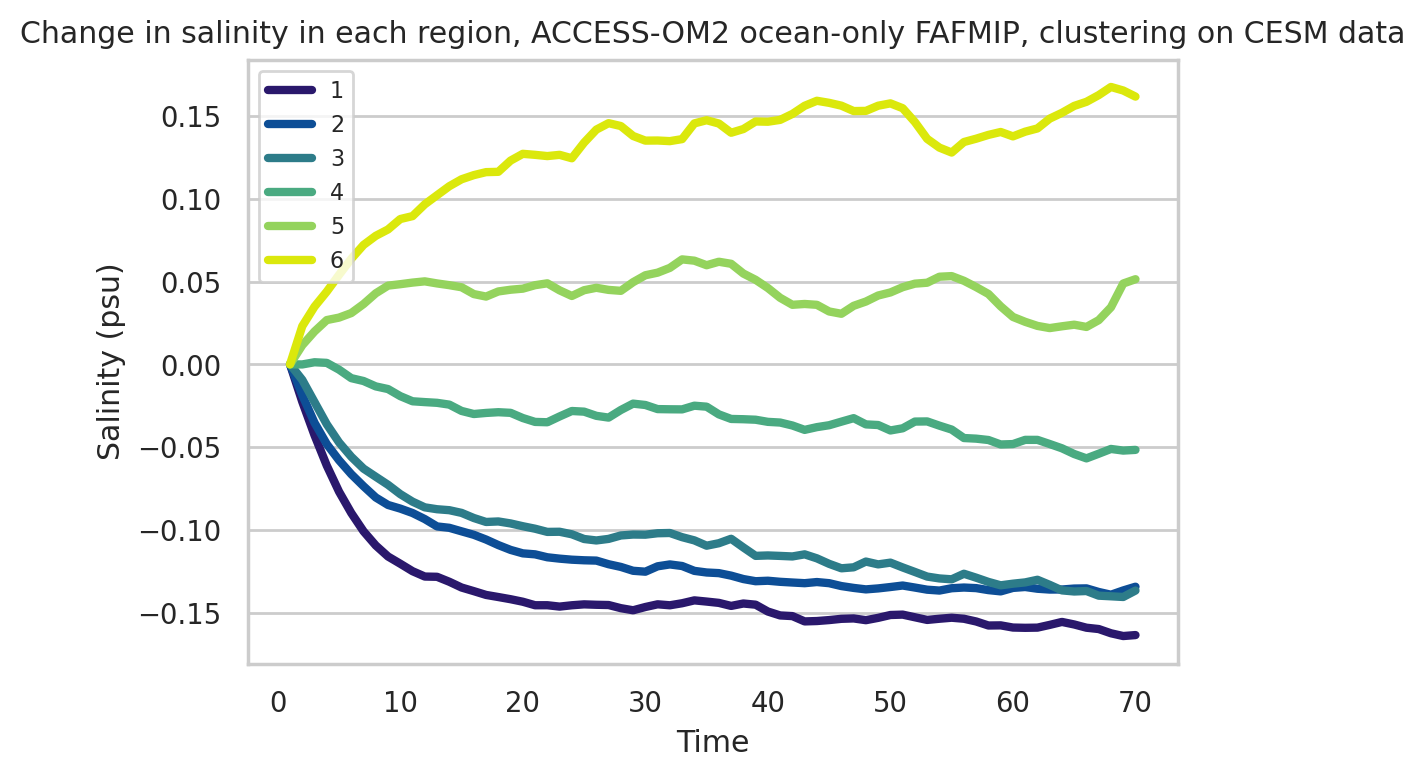

In [36]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_access_water-np.mean(salt_access_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, ACCESS-OM2 ocean-only FAFMIP, clustering on CESM data')

Text(0.5, 1.0, 'Change in salinity in each region, HadOM3 ocean-only FAFMIP, clustering on CESM data')

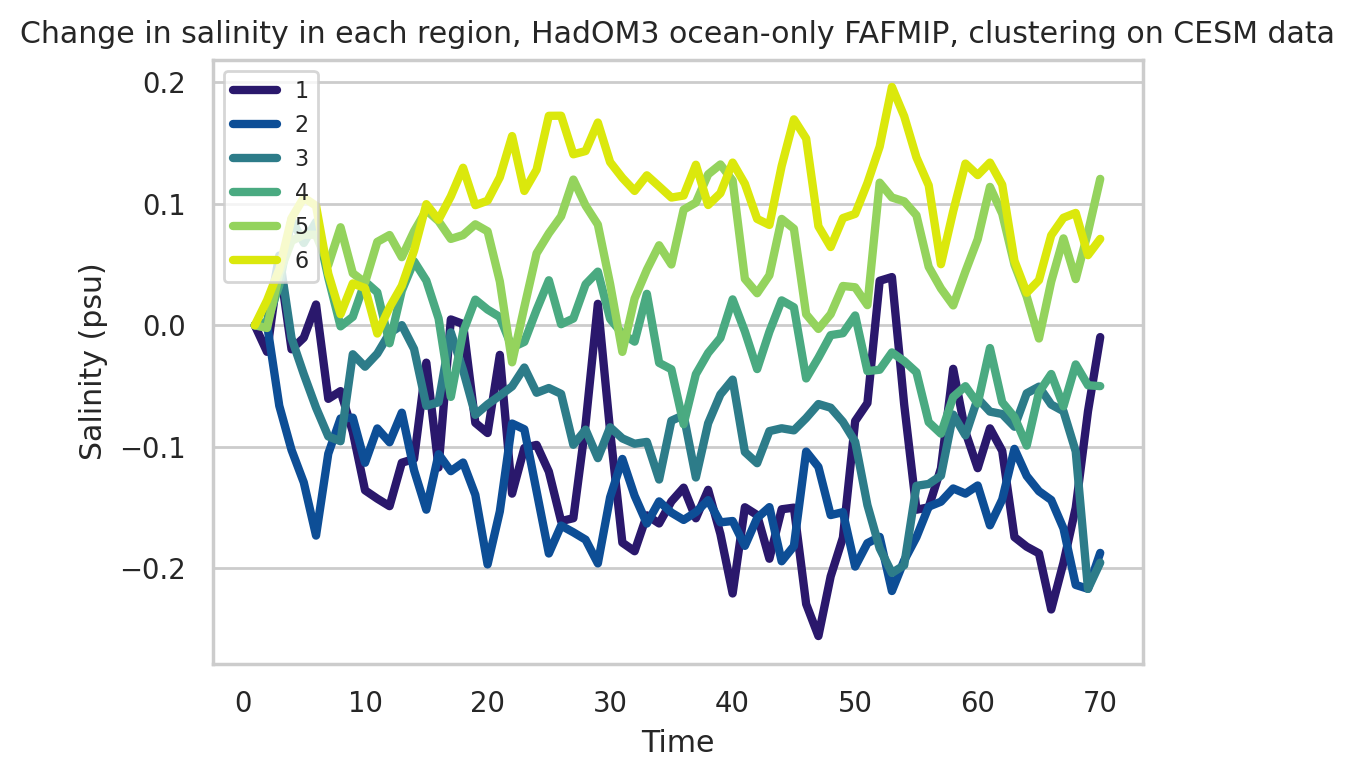

In [37]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_had_water-np.mean(salt_had_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, HadOM3 ocean-only FAFMIP, clustering on CESM data')

## Plots generated in form needed for paper. Here we need the distribution and map with labels added (a) and (b).

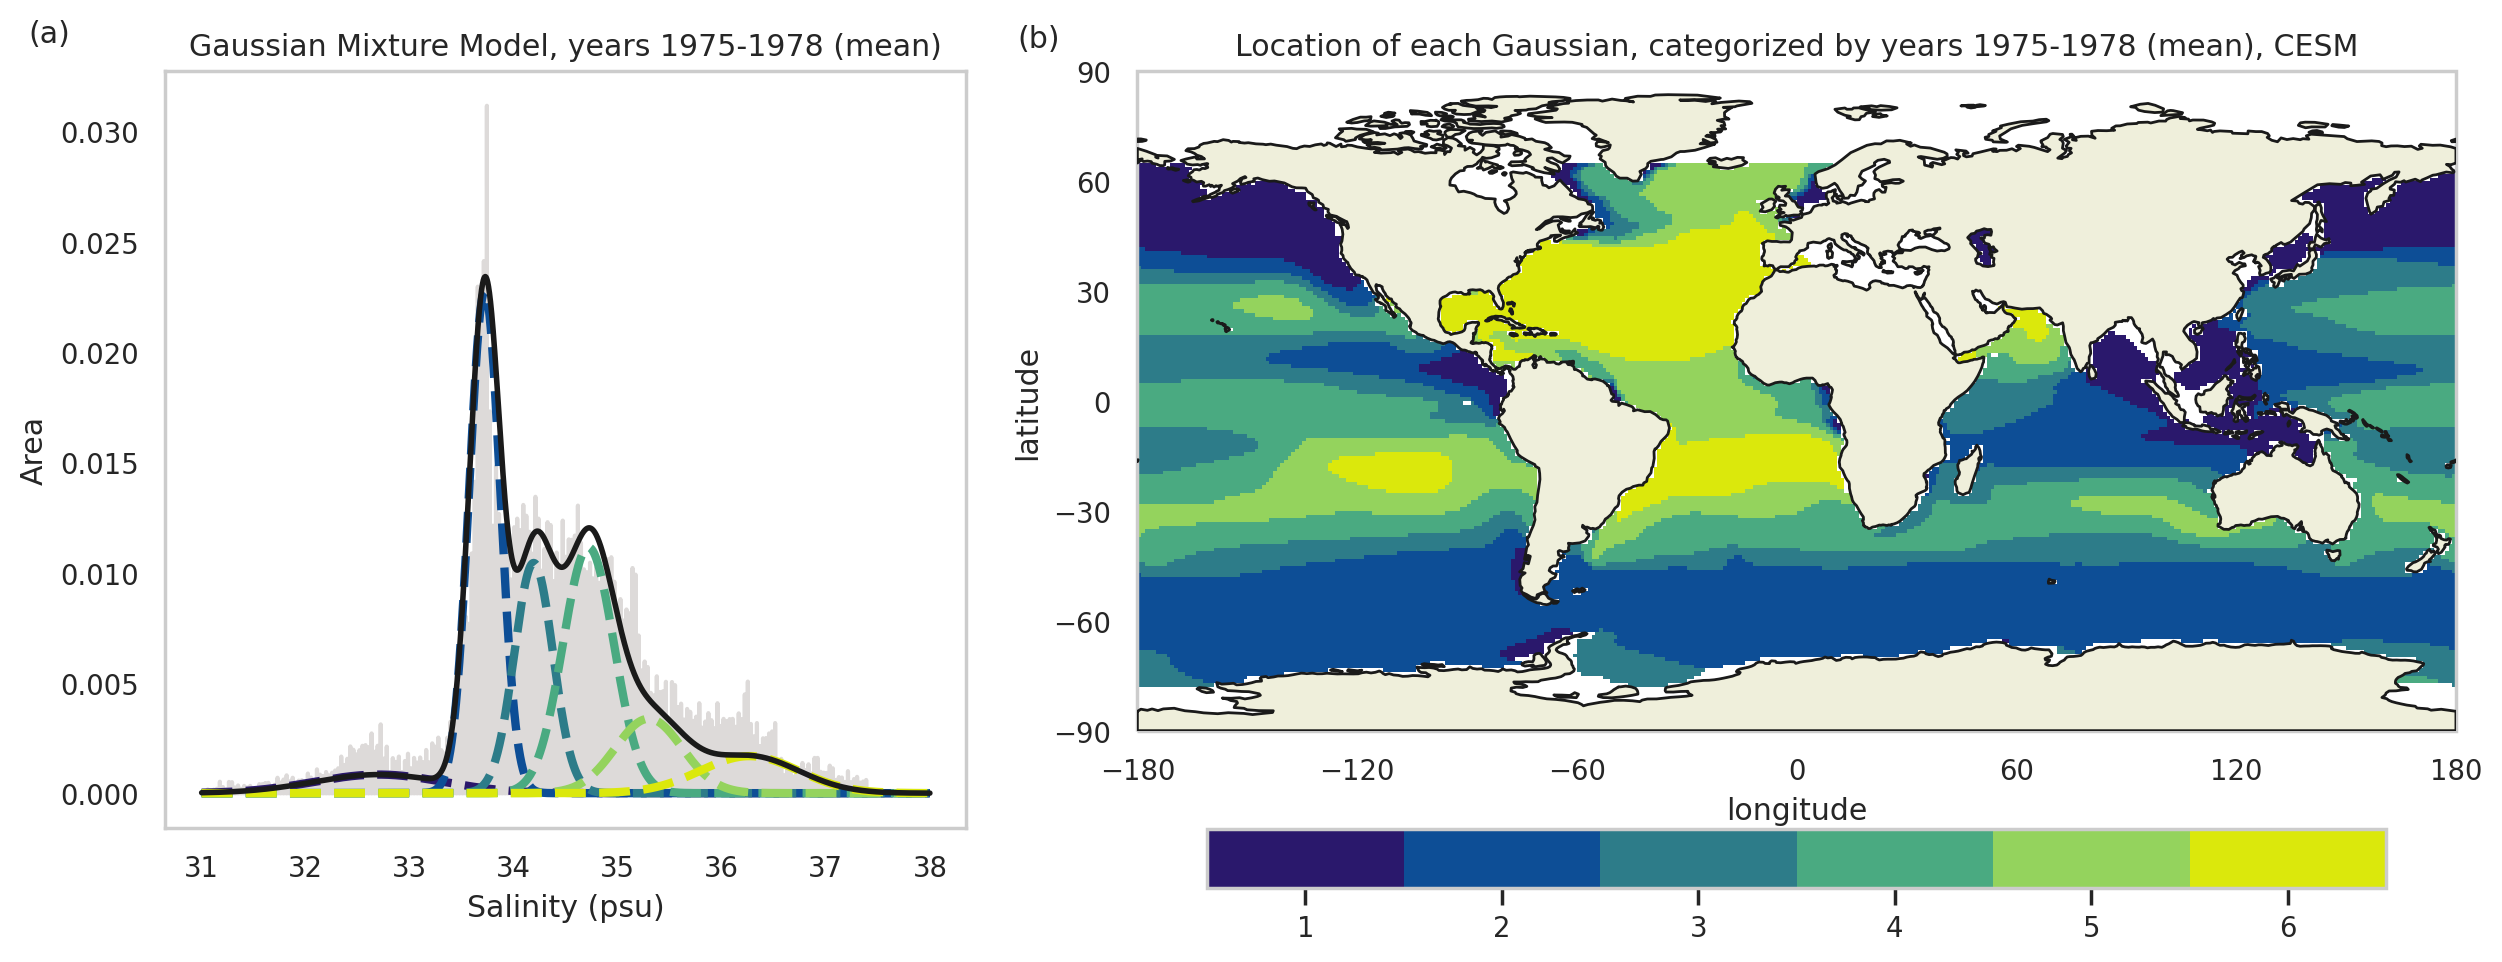

In [39]:
from clustering_tools import GMM_plot_withmap

GMM_plot_withmap(salt_avg_1975to2020[0*12:3*12,:,:].mean('time'),n,', years 1975-1978 (mean)','Location of each Gaussian, categorized by years 1975-1978 (mean), CESM',subplot_label='(a)',subplot_label2='(b)') 
mpl.pyplot.savefig('CESM_GMM_andmap.png', dpi=300,bbox_inches='tight')